In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score
import gc
import time
import os
from typing import List, Optional

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
sns.set(style='darkgrid')

In [ ]:
# Load data
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def load_cicids_data(folder_path: str,
                     chunksize: int = 100000) -> pd.DataFrame:
    """
    Load CICIDS2017 dataset in a memory-efficient manner.

    Args:
        folder_path: Path to the folder containing CSV files
        usecols: List of columns to load (None loads all columns)
        chunksize: Number of rows to read at a time

    Returns:
        Combined DataFrame with all data
    """
    # List to store DataFrames
    combined_df = None

    # Load the datasets
    for dirname, _, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.csv'):
                file_path = os.path.join(dirname, filename)

                # Get total rows in file
                total_rows = sum(1 for _ in open(file_path)) - 1
                print(f"\nProcessing {filename} ({total_rows:,} rows)")

                # Read file in chunks
                chunk_iterator = pd.read_csv(
                    file_path,
                    chunksize=chunksize,
                    low_memory=True
                )

                for i, chunk in enumerate(chunk_iterator):
                    # Process chunk
                    if combined_df is None:
                        combined_df = chunk
                    else:
                        combined_df = pd.concat([combined_df, chunk], ignore_index=True)

                    # Print progress
                    rows_processed = min((i + 1) * chunksize, total_rows)
                    print(f"Progress: {rows_processed:,}/{total_rows:,} rows", end='\r')

                    # Force garbage collection
                    gc.collect()

                print(f"\nCompleted {filename}")

    return combined_df

# Usage example
folder_path = '/content/drive/MyDrive/Capstone /CICIDS2017'


# Load data efficiently
data = load_cicids_data(
    folder_path=folder_path,
    chunksize=100000
)


Processing Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (225,745 rows)
Progress: 225,745/225,745 rows
Completed Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (286,467 rows)
Progress: 286,467/286,467 rows
Completed Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv

Processing Friday-WorkingHours-Morning.pcap_ISCX.csv (191,033 rows)
Progress: 191,033/191,033 rows
Completed Friday-WorkingHours-Morning.pcap_ISCX.csv

Processing Monday-WorkingHours.pcap_ISCX.csv (529,918 rows)
Progress: 529,918/529,918 rows
Completed Monday-WorkingHours.pcap_ISCX.csv

Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (288,602 rows)
Progress: 288,602/288,602 rows
Completed Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv

Processing Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (170,366 rows)
Progress: 170,366/170,366 rows
Completed Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv

Proce

In [ ]:
print(f"Dataset shape: {data.shape}")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Number of features: {data.shape[1]}")
print(f"Number of samples: {data.shape[0]}")

Dataset shape: (2830743, 79)
Memory usage: 1855.48 MB
Number of features: 79
Number of samples: 2830743


In [ ]:
# Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

In [ ]:
print(data.dtypes.value_counts())

int64      54
float64    24
object      1
Name: count, dtype: int64


In [ ]:
def optimize_dtypes(df):
    for col in df.columns:
        if df[col].dtype == 'float64':
            df[col] = df[col].astype('float32')
        elif df[col].dtype == 'int64':
            df[col] = df[col].astype('int32')
    return df

data = optimize_dtypes(data)

In [ ]:
print(data.dtypes.value_counts())
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

int32      54
float32    24
object      1
Name: count, dtype: int64
Memory usage: 1013.20 MB


In [ ]:
dups = data[data.duplicated()]
print(f'Number of duplicates: {len(dups)}')

Number of duplicates: 330995


In [ ]:
dup_rows = data[data.duplicated(keep=False)]
dup_label_counts = dup_rows['Label'].value_counts()
print(dup_label_counts)

Label
BENIGN                      263847
PortScan                    101501
DoS Hulk                     59564
SSH-Patator                   2826
FTP-Patator                   2457
DoS slowloris                  507
DoS Slowhttptest               323
Web Attack � Brute Force        62
DDoS                            20
Bot                             19
DoS GoldenEye                   14
Name: count, dtype: int64


In [ ]:
class_counts_before = data['Label'].value_counts()
data_no_dup = data.drop_duplicates()
class_counts_after = data_no_dup['Label'].value_counts()
pd.concat([class_counts_before, class_counts_after], axis=1, keys=['Before', 'After'])

Before    After
Label                                       
BENIGN                      2273097  2073870
DoS Hulk                     231073   172849
PortScan                     158930    90819
DDoS                         128027   128016
DoS GoldenEye                 10293    10286
FTP-Patator                    7938     5933
SSH-Patator                    5897     3219
DoS slowloris                  5796     5385
DoS Slowhttptest               5499     5228
Bot                            1966     1953
Web Attack � Brute Force       1507     1470
Web Attack � XSS                652      652
Infiltration                     36       36
Web Attack � Sql Injection       21       21
Heartbleed                       11       11

In [ ]:
data = data.drop_duplicates(keep='first')
gc.collect()

31

In [ ]:
print(f"New shape: {data.shape}")
print(data['Label'].value_counts())

New shape: (2499748, 79)
Label
BENIGN                        2073870
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


Identify Missing Values

In [ ]:
missing_val = data.isna().sum()
print(missing_val.loc[missing_val > 0])

Flow Bytes/s    353
dtype: int64


In [ ]:
# Checking for infinity values
numeric_cols = data.select_dtypes(include = np.number).columns
inf_count = np.isinf(data[numeric_cols]).sum()
print(inf_count[inf_count > 0])

Flow Bytes/s      1210
Flow Packets/s    1563
dtype: int64


In [ ]:
# Replacing any infinite values (positive or negative) with NaN (not a number)
print(f'Initial missing values: {data.isna().sum().sum()}')

data.replace([np.inf, -np.inf], np.nan, inplace = True)

print(f'Missing values after processing infinite values: {data.isna().sum().sum()}')

Initial missing values: 353
Missing values after processing infinite values: 3126


In [ ]:
missing = data.isna().sum()
print(missing.loc[missing > 0])

Flow Bytes/s      1563
Flow Packets/s    1563
dtype: int64


In [ ]:
# Calculating missing value percentage in the dataset
mis_per = (missing / len(data)) * 100
mis_table = pd.concat([missing, mis_per.round(2)], axis = 1)
mis_table = mis_table.rename(columns = {0 : 'Missing Values', 1 : 'Percentage of Total Values'})

print(mis_table.loc[mis_per > 0])

                Missing Values  Percentage of Total Values
Flow Bytes/s              1563                        0.06
Flow Packets/s            1563                        0.06


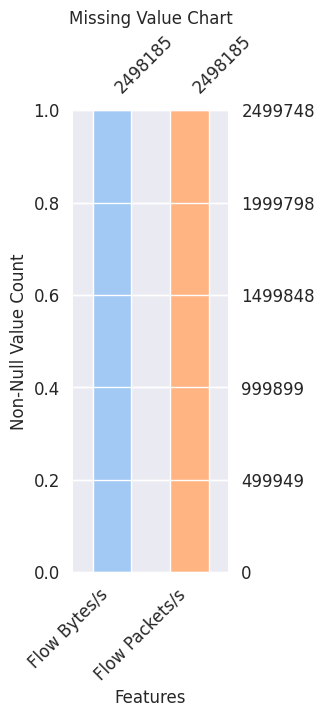

In [ ]:
sns.set_palette('pastel')
colors = sns.color_palette()

missing_vals = [col for col in data.columns if data[col].isna().any()]

fig, ax = plt.subplots(figsize = (2, 6))
msno.bar(data[missing_vals], ax = ax, fontsize = 12, color = colors)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Non-Null Value Count', fontsize = 12)
ax.set_title('Missing Value Chart', fontsize = 12)
plt.show()

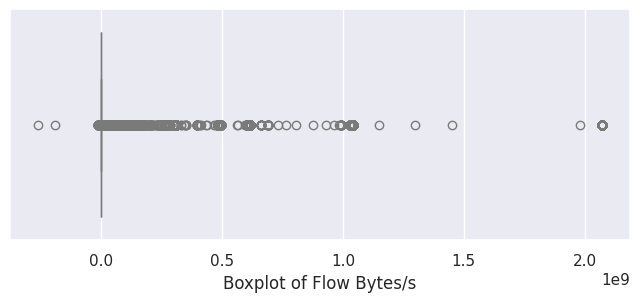

In [ ]:
plt.figure(figsize = (8, 3))
sns.boxplot(x = data['Flow Bytes/s'])
plt.xlabel('Boxplot of Flow Bytes/s')
plt.show()

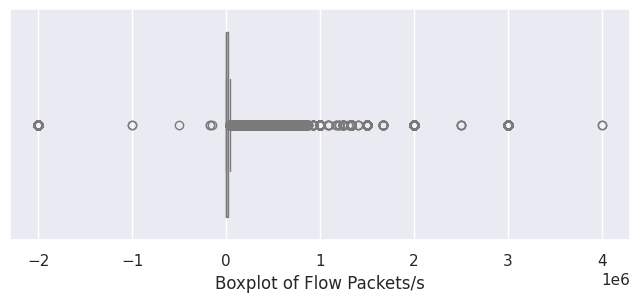

In [ ]:
plt.figure(figsize = (8, 3))
sns.boxplot(x = data['Flow Packets/s'])
plt.xlabel('Boxplot of Flow Packets/s')
plt.show()


In [ ]:
med_flow_bytes = data['Flow Bytes/s'].median()
med_flow_packets = data['Flow Packets/s'].median()

print('Median of Flow Bytes/s: ', med_flow_bytes)
print('Median of Flow Packets/s: ', med_flow_packets)

Median of Flow Bytes/s:  3613.71923828125
Median of Flow Packets/s:  66.51036834716797


In [ ]:
# Filling missing values with median
data['Flow Bytes/s'].fillna(med_flow_bytes, inplace = True)
data['Flow Packets/s'].fillna(med_flow_packets, inplace = True)

In [ ]:
print('Number of \'Flow Bytes/s\' missing values:', data['Flow Bytes/s'].isna().sum())
print('Number of \'Flow Packets/s\' missing values:', data['Flow Packets/s'].isna().sum())

Number of 'Flow Bytes/s' missing values: 0
Number of 'Flow Packets/s' missing values: 0


In [ ]:
# Types of attacks & normal instances (BENIGN)
data['Label'].value_counts()

Label
BENIGN                        2073870
DoS Hulk                       172849
DDoS                           128016
PortScan                        90819
DoS GoldenEye                   10286
FTP-Patator                      5933
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1953
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [ ]:
# Creating a dictionary that maps each label to its attack type
attack_map = {
    'BENIGN': 'BENIGN',
    'DDoS': 'DDoS',
    'DoS Hulk': 'DoS',
    'DoS GoldenEye': 'DoS',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'PortScan': 'Port Scan',
    'FTP-Patator': 'Brute Force',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bot',
    'Web Attack � Brute Force': 'Web Attack',
    'Web Attack � XSS': 'Web Attack',
    'Web Attack � Sql Injection': 'Web Attack',
    'Infiltration': 'Infiltration',
    'Heartbleed': 'Heartbleed'
}

# Creating a new column 'Attack Type' in the DataFrame based on the attack_map dictionary
data['Attack Type'] = data['Label'].map(attack_map)

In [ ]:
data['Attack Type'].value_counts()

Attack Type
BENIGN          2073870
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [ ]:
data.drop('Label', axis = 1, inplace = True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Attack Number'] = le.fit_transform(data['Attack Type'])

print(data['Attack Number'].unique())

[0 3 7 1 6 8 2 4 5]


In [ ]:
# Printing corresponding attack type for each encoded value
encoded_values = data['Attack Number'].unique()
for val in sorted(encoded_values):
    print(f"{val}: {le.inverse_transform([val])[0]}")

0: BENIGN
1: Bot
2: Brute Force
3: DDoS
4: DoS
5: Heartbleed
6: Infiltration
7: Port Scan
8: Web Attack


In [ ]:
# Checking for columns with zero standard deviation (the blank squares in the heatmap)
std = data.std(numeric_only = True)
zero_std_cols = std[std == 0].index.tolist()
zero_std_cols

['Bwd PSH Flags',
 'Bwd URG Flags',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

Correlation Matrix

In [ ]:
corr = data.corr(numeric_only = True).round(2)
corr.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)

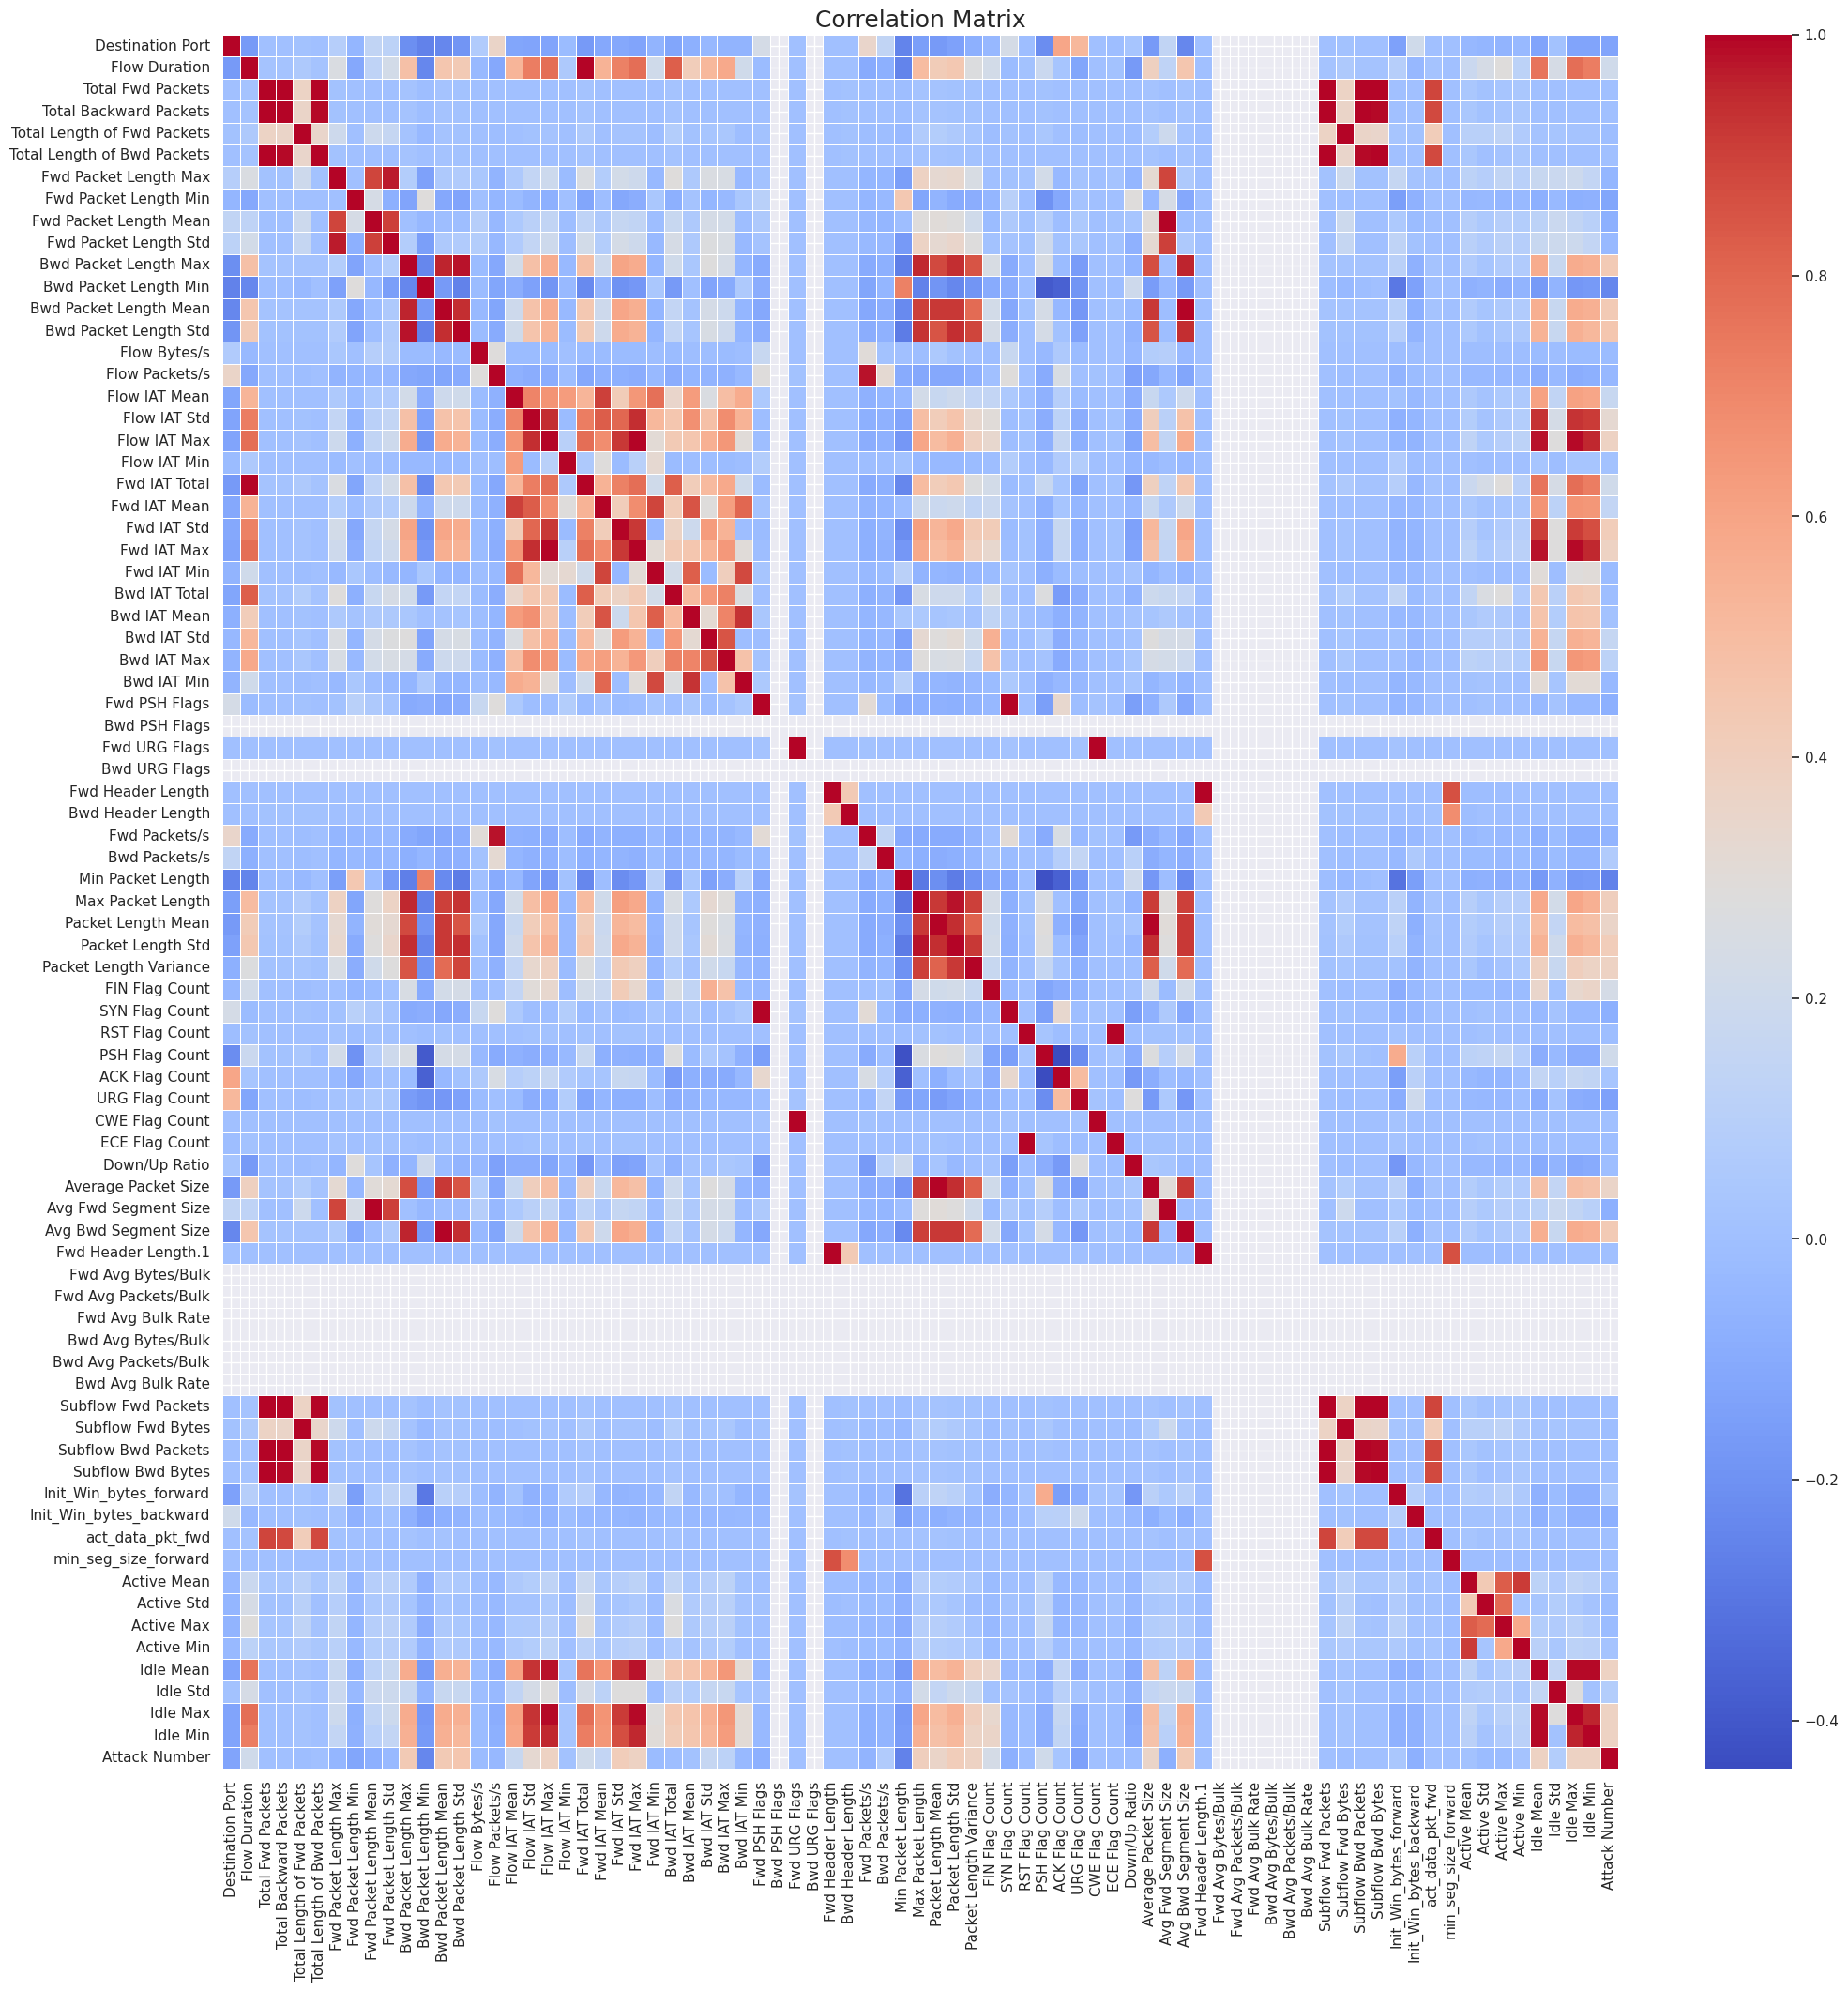

In [ ]:
fig, ax = plt.subplots(figsize = (24, 24))
sns.heatmap(corr, cmap = 'coolwarm', annot = False, linewidth = 0.5)
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

In [ ]:
# Positive correlation features for 'Attack Number'
pos_corr_features = corr['Attack Number'][(corr['Attack Number'] > 0) & (corr['Attack Number'] < 1)].index.tolist()

print("Features with positive correlation with 'Attack Number':\n")
for i, feature in enumerate(pos_corr_features, start = 1):
    corr_value = corr.loc[feature, 'Attack Number']
    print('{:<3} {:<24} :{}'.format(f'{i}.', feature, corr_value))

Features with positive correlation with 'Attack Number':

1.  Flow Duration            :0.21
2.  Bwd Packet Length Max    :0.43
3.  Bwd Packet Length Mean   :0.43
4.  Bwd Packet Length Std    :0.45
5.  Flow IAT Mean            :0.17
6.  Flow IAT Std             :0.33
7.  Flow IAT Max             :0.38
8.  Flow IAT Min             :0.01
9.  Fwd IAT Total            :0.21
10. Fwd IAT Mean             :0.15
11. Fwd IAT Std              :0.41
12. Fwd IAT Max              :0.38
13. Bwd IAT Mean             :0.01
14. Bwd IAT Std              :0.16
15. Bwd IAT Max              :0.12
16. Bwd Packets/s            :0.07
17. Max Packet Length        :0.4
18. Packet Length Mean       :0.36
19. Packet Length Std        :0.41
20. Packet Length Variance   :0.38
21. FIN Flag Count           :0.23
22. PSH Flag Count           :0.21
23. ACK Flag Count           :0.03
24. Average Packet Size      :0.36
25. Avg Bwd Segment Size     :0.43
26. Init_Win_bytes_forward   :0.04
27. Active Mean              :0.0

In [ ]:
print(f'Number of considerable important features: {len(pos_corr_features)}')

Number of considerable important features: 32


In [ ]:
# Data sampling for data analysis
sample_size = int(0.2 * len(data)) # 20% of the original size
sampled_data = data.sample(n = sample_size, replace = False, random_state = 0)
sampled_data.shape

(499949, 80)

In [ ]:
# To assess if a sample is representative of the population and comparison of descriptive statistics (mean)
numeric_cols = data.select_dtypes(include = [np.number]).columns.tolist()
print('Descriptive Statistics Comparison (mean):\n')
print('{:<32s}{:<22s}{:<22s}{}'.format('Feature', 'Original Dataset', 'Sampled Dataset', 'Variation Percentage'))
print('-' * 96)

high_variations = []
for col in numeric_cols:
    old = data[col].describe()[1]
    new = sampled_data[col].describe()[1]
    if old == 0:
        pct = 0
    else:
        pct = abs((new - old) / old)
    if pct * 100 > 5:
        high_variations.append((col, pct * 100))
    print('{:<32s}{:<22.6f}{:<22.6f}{:<2.2%}'.format(col, old, new, pct))

Descriptive Statistics Comparison (mean):

Feature                         Original Dataset      Sampled Dataset       Variation Percentage
------------------------------------------------------------------------------------------------
Destination Port                8780.493478           8750.527640           0.34%
Flow Duration                   16731251.623353       16815391.000380       0.50%
Total Fwd Packets               10.352338             11.162251             7.82%
Total Backward Packets          11.656425             12.755183             9.43%
Total Length of Fwd Packets     616.520797            604.681594            1.92%
Total Length of Bwd Packets     18295.990096          20760.740055          13.47%
Fwd Packet Length Max           232.868734            234.358501            0.64%
Fwd Packet Length Min           19.059739             19.116634             0.30%
Fwd Packet Length Mean          63.733311             64.103287             0.58%
Fwd Packet Length Std   

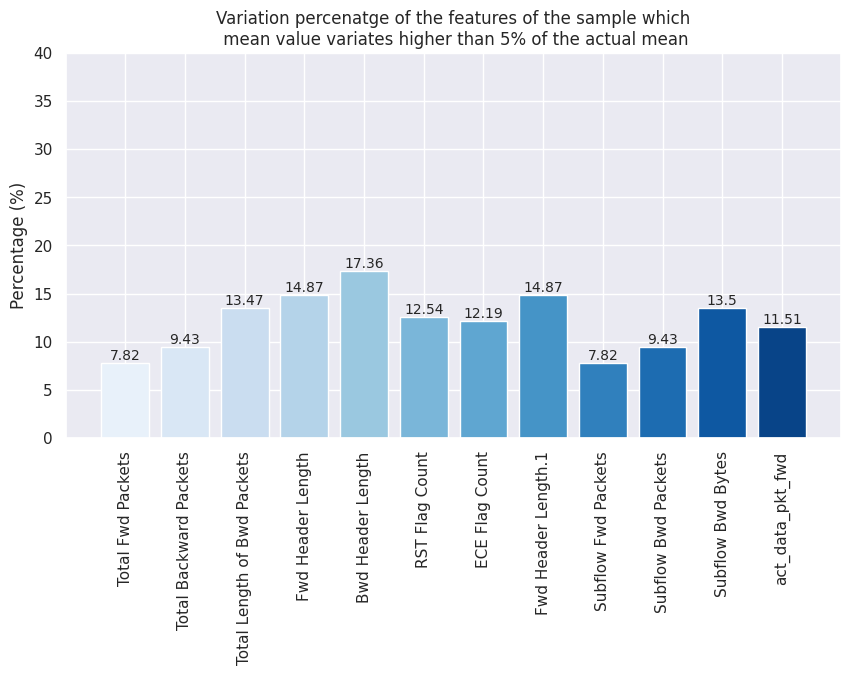

In [ ]:
labels = [t[0] for t in high_variations]
values = [t[1] for t in high_variations]

colors = sns.color_palette('Blues', n_colors=len(labels))
fig, ax = plt.subplots(figsize = (10, 5))
ax.bar(labels, values, color = colors)

for i in range(len(labels)):
    ax.text(i, values[i], str(round(values[i], 2)), ha = 'center', va = 'bottom', fontsize = 10)

plt.xticks(rotation = 90)
ax.set_title('Variation percenatge of the features of the sample which\n mean value variates higher than 5% of the actual mean')
ax.set_ylabel('Percentage (%)')
ax.set_yticks(np.arange(0, 41, 5))
plt.show()

In [ ]:
# Printing the unique value count
indent = '{:<3} {:<30}: {}'
print('Unique value count for: ')
for i, feature in enumerate(list(sampled_data.columns)[:-1], start = 1):
    print(indent.format(f'{i}.', feature, sampled_data[feature].nunique()))

Unique value count for: 
1.  Destination Port              : 33374
2.  Flow Duration                 : 256763
3.  Total Fwd Packets             : 693
4.  Total Backward Packets        : 864
5.  Total Length of Fwd Packets   : 9079
6.  Total Length of Bwd Packets   : 24243
7.  Fwd Packet Length Max         : 3676
8.  Fwd Packet Length Min         : 252
9.  Fwd Packet Length Mean        : 31646
10. Fwd Packet Length Std         : 63771
11. Bwd Packet Length Max         : 3934
12. Bwd Packet Length Min         : 448
13. Bwd Packet Length Mean        : 43104
14. Bwd Packet Length Std         : 60300
15. Flow Bytes/s                  : 337714
16. Flow Packets/s                : 275240
17. Flow IAT Mean                 : 270243
18. Flow IAT Std                  : 220260
19. Flow IAT Max                  : 167246
20. Flow IAT Min                  : 45873
21. Fwd IAT Total                 : 119681
22. Fwd IAT Mean                  : 163833
23. Fwd IAT Std                   : 146445
24. Fwd IAT

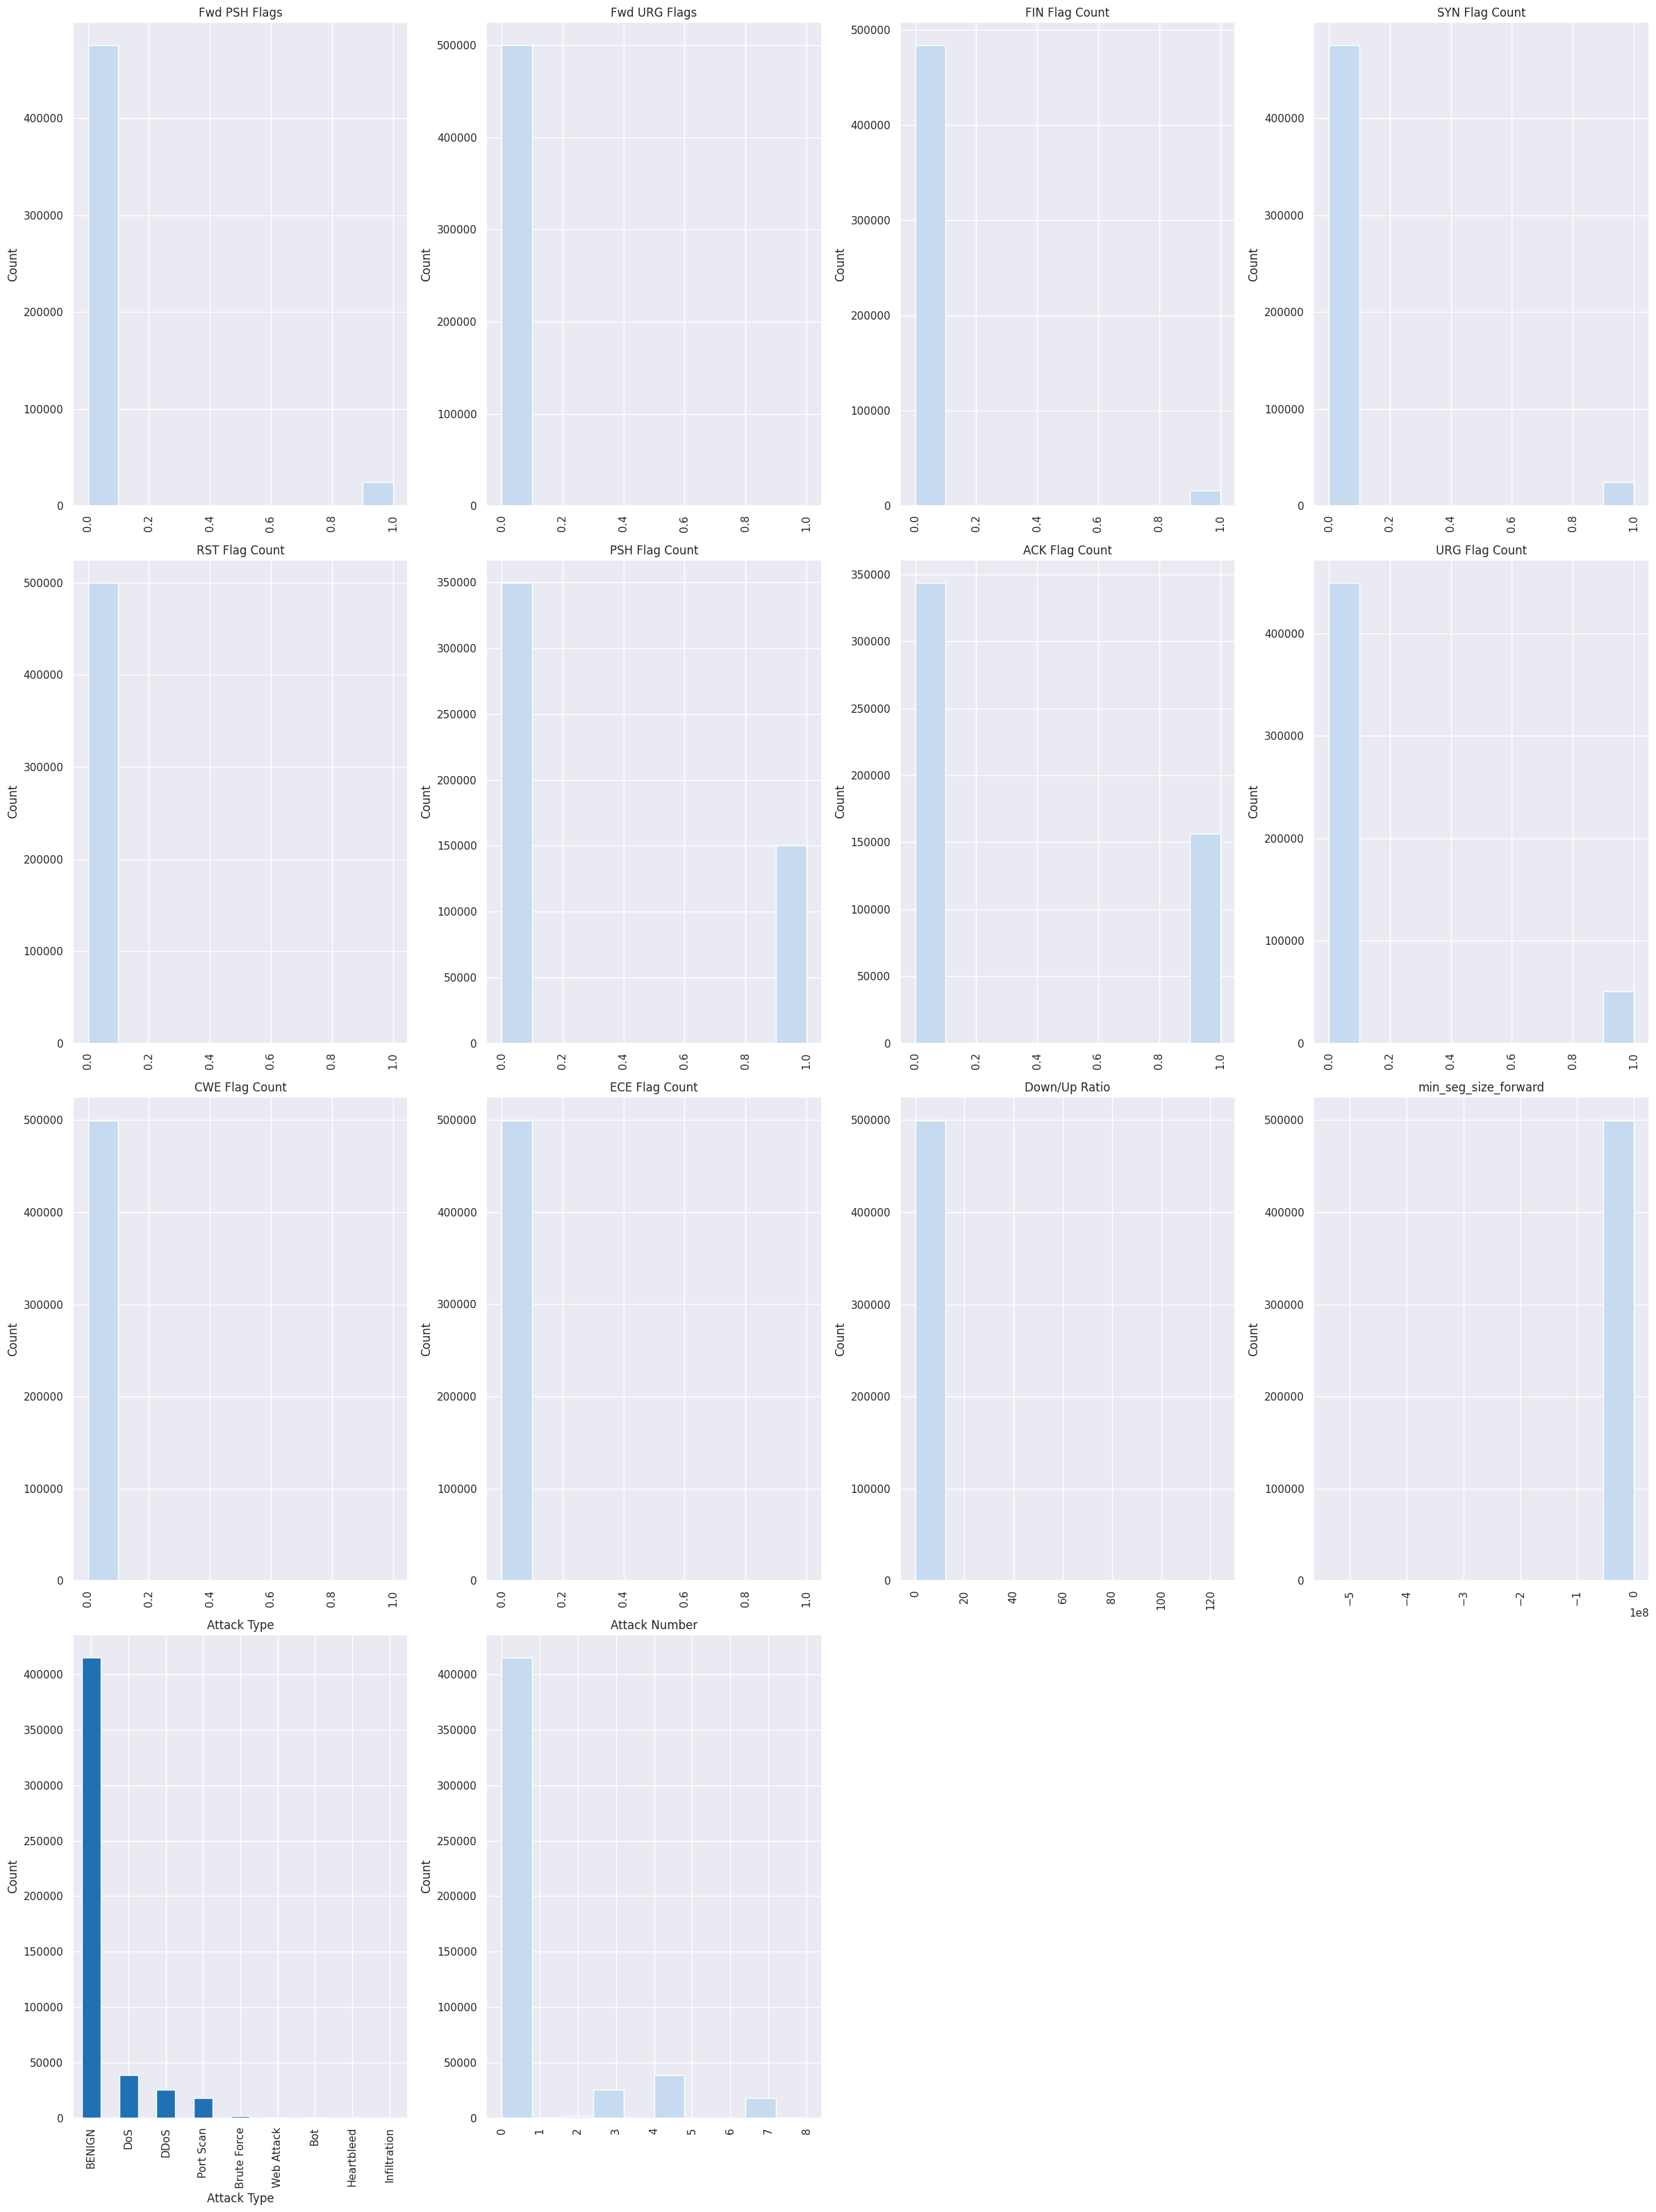

In [ ]:

'''Generating a set of visualizations for columns that have more than one unique value but less than 50 unique values.
For categorical columns, a bar plot is generated showing the count of each unique value.
For numerical columns, a histogram is generated.'''
unique_values = sampled_data.nunique()
selected_cols = sampled_data[[col for col in sampled_data if 1 < unique_values[col] < 50]]
rows, cols = selected_cols.shape
col_names = list(selected_cols)
num_of_rows = (cols + 3) // 4

color_palette = sns.color_palette('Blues', n_colors = 3)
plt.figure(figsize = (6 * 4, 8 * num_of_rows))

for i in range(cols):
    plt.subplot(num_of_rows, 4, i + 1)
    col_data = selected_cols.iloc[:, i]
    if col_data.dtype.name == 'object':
        col_data.value_counts().plot(kind = 'bar', color = color_palette[2])
    else:
        col_data.hist(color = color_palette[0])

    plt.ylabel('Count')
    plt.xticks(rotation = 90)
    plt.title(col_names[i])

plt.tight_layout()
plt.show()


In [ ]:
# Correlation matrix for sampled data
corr_matrix = sampled_data.corr(numeric_only = True).round(2)
corr_matrix.style.background_gradient(cmap = 'coolwarm', axis = None).format(precision = 2)


In [ ]:
sampled_data.drop('Attack Number', axis = 1, inplace = True)
data.drop('Attack Number', axis = 1, inplace = True)

Outliers

In [ ]:
# Identifying outliers
numeric_data = sampled_data.select_dtypes(include = ['float', 'int'])
q1 = numeric_data.quantile(0.25)
q3 = numeric_data.quantile(0.75)
iqr = q3 - q1
outlier = (numeric_data < (q1 - 1.5 * iqr)) | (numeric_data > (q3 + 1.5 * iqr))
outlier_count = outlier.sum()
outlier_percentage = round(outlier.mean() * 100, 2)
outlier_stats = pd.concat([outlier_count, outlier_percentage], axis = 1)
outlier_stats.columns = ['Outlier Count', 'Outlier Percentage']

print(outlier_stats)

                             Outlier Count  Outlier Percentage
Destination Port                    108943               21.79
Flow Duration                        93900               18.78
Total Fwd Packets                    50924               10.19
Total Backward Packets               48319                9.66
Total Length of Fwd Packets          62758               12.55
...                                    ...                 ...
Active Min                          112203               22.44
Idle Mean                           113897               22.78
Idle Std                             46176                9.24
Idle Max                            113897               22.78
Idle Min                            113897               22.78

[78 rows x 2 columns]


In [ ]:
# Identifying outliers based on attack type
outlier_counts = {}
for i in numeric_data:
    for attack_type in sampled_data['Attack Type'].unique():
        attack_data = sampled_data[i][sampled_data['Attack Type'] == attack_type]
        q1, q3 = np.percentile(attack_data, [25, 75])
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        num_outliers = ((attack_data < lower_bound) | (attack_data > upper_bound)).sum()
        outlier_percent = num_outliers / len(attack_data) * 100
        outlier_counts[(i, attack_type)] = (num_outliers, outlier_percent)

for i in numeric_data:
  print(f'Feature: {i}')
  for attack_type in sampled_data['Attack Type'].unique():
    num_outliers, outlier_percent = outlier_counts[(i, attack_type)]
    print(f'- {attack_type}: {num_outliers} ({outlier_percent:.2f}%)')
  print()

Feature: Destination Port
- BENIGN: 93454 (22.52%)
- DoS: 0 (0.00%)
- Port Scan: 2227 (12.34%)
- DDoS: 0 (0.00%)
- Bot: 148 (37.76%)
- Web Attack: 0 (0.00%)
- Brute Force: 0 (0.00%)
- Heartbleed: 0 (0.00%)
- Infiltration: 0 (0.00%)

Feature: Flow Duration
- BENIGN: 96422 (23.23%)
- DoS: 8439 (21.74%)
- Port Scan: 402 (2.23%)
- DDoS: 4340 (17.11%)
- Bot: 89 (22.70%)
- Web Attack: 73 (17.76%)
- Brute Force: 0 (0.00%)
- Heartbleed: 1 (25.00%)
- Infiltration: 0 (0.00%)

Feature: Total Fwd Packets
- BENIGN: 78210 (18.85%)
- DoS: 496 (1.28%)
- Port Scan: 286 (1.58%)
- DDoS: 814 (3.21%)
- Bot: 9 (2.30%)
- Web Attack: 73 (17.76%)
- Brute Force: 0 (0.00%)
- Heartbleed: 1 (25.00%)
- Infiltration: 1 (25.00%)

Feature: Total Backward Packets
- BENIGN: 60575 (14.60%)
- DoS: 4572 (11.78%)
- Port Scan: 97 (0.54%)
- DDoS: 0 (0.00%)
- Bot: 9 (2.30%)
- Web Attack: 47 (11.44%)
- Brute Force: 0 (0.00%)
- Heartbleed: 1 (25.00%)
- Infiltration: 1 (25.00%)

Feature: Total Length of Fwd Packets
- BENIGN: 7085

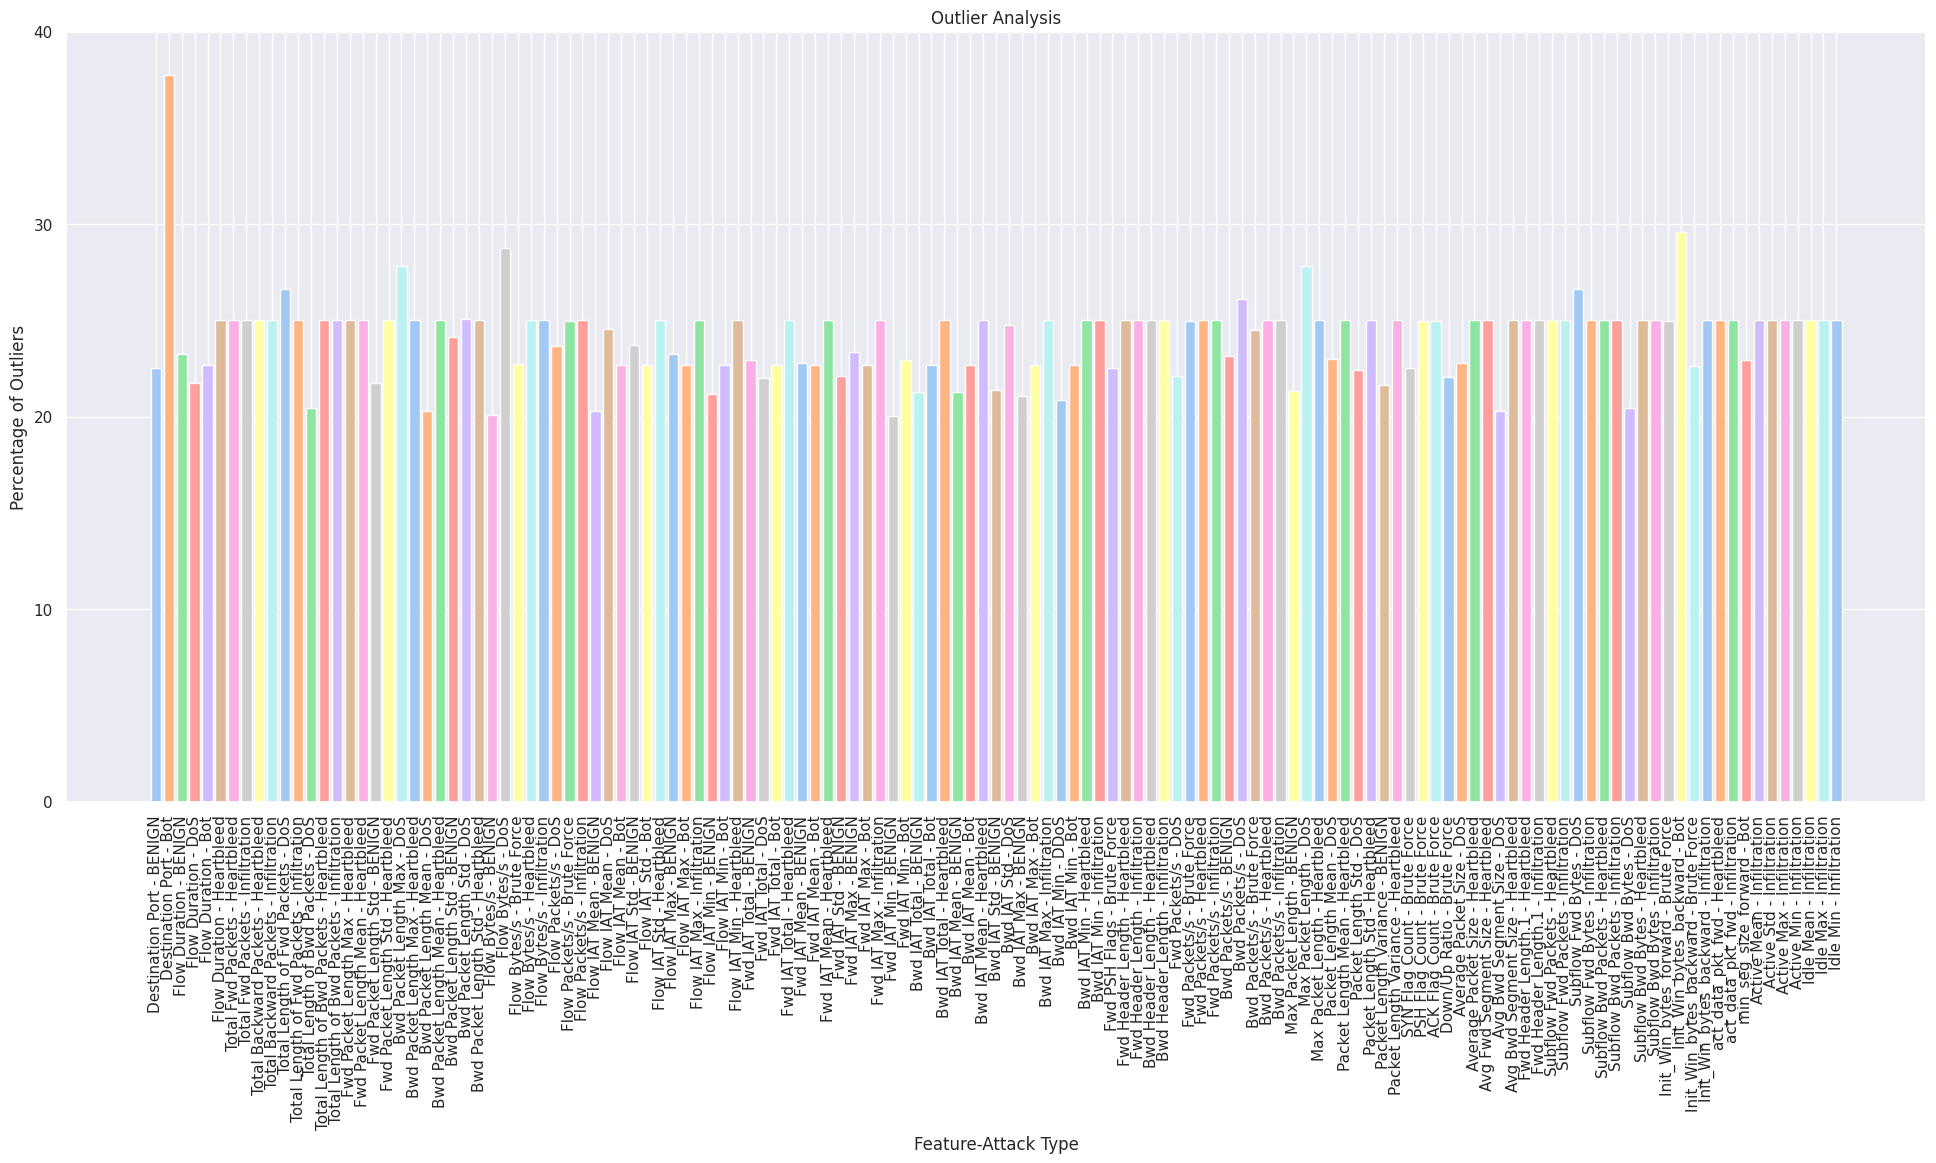

In [ ]:
# Plotting the percentage of outliers that are higher than 20%
fig, ax = plt.subplots(figsize = (24, 10))
for i in numeric_data:
    for attack_type in sampled_data['Attack Type'].unique():
        num_outliers, outlier_percent = outlier_counts[(i, attack_type)]
        if outlier_percent > 20:
            ax.bar(f'{i} - {attack_type}', outlier_percent)

ax.set_xlabel('Feature-Attack Type')
ax.set_ylabel('Percentage of Outliers')
ax.set_title('Outlier Analysis')
ax.set_yticks(np.arange(0, 41, 10))
plt.xticks(rotation = 90)
plt.show()

# Preprocessing

In [ ]:
# For improving performance and reduce memory-related errors
old_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f'Initial memory usage: {old_memory_usage:.2f} MB')
for col in data.columns:
    col_type = data[col].dtype
    if col_type != object:
        c_min = data[col].min()
        c_max = data[col].max()
        # Downcasting float64 to float32
        if str(col_type).find('float') >= 0 and c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            data[col] = data[col].astype(np.float32)

        # Downcasting int64 to int32
        elif str(col_type).find('int') >= 0 and c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
            data[col] = data[col].astype(np.int32)

new_memory_usage = data.memory_usage().sum() / 1024 ** 2
print(f"Final memory usage: {new_memory_usage:.2f} MB")

Initial memory usage: 781.93 MB
Final memory usage: 781.93 MB


In [ ]:
# Dropping columns with only one unique value
num_unique = data.nunique()
one_variable = num_unique[num_unique == 1]
not_one_variable = num_unique[num_unique > 1].index

dropped_cols = one_variable.index
data = data[not_one_variable]

print('Dropped columns:')
dropped_cols

Dropped columns:


Index(['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk',
       'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk',
       'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'],
      dtype='object')

In [ ]:
data.shape

(2499748, 71)

In [ ]:
data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count',

In [ ]:
data = data.drop('Fwd Header Length.1', axis=1)

In [ ]:
feature_mapping = {
    'Destination Port': 'Dst Port',
    'Flow Duration': 'Flow Duration',
    'Total Fwd Packets': 'Tot Fwd Pkts',
    'Total Backward Packets': 'Tot Bwd Pkts',
    'Total Length of Fwd Packets': 'TotLen Fwd Pkts',
    'Total Length of Bwd Packets': 'TotLen Bwd Pkts',
    'Fwd Packet Length Max': 'Fwd Pkt Len Max',
    'Fwd Packet Length Min': 'Fwd Pkt Len Min',
    'Fwd Packet Length Mean': 'Fwd Pkt Len Mean',
    'Fwd Packet Length Std': 'Fwd Pkt Len Std',
    'Bwd Packet Length Max': 'Bwd Pkt Len Max',
    'Bwd Packet Length Min': 'Bwd Pkt Len Min',
    'Bwd Packet Length Mean': 'Bwd Pkt Len Mean',
    'Bwd Packet Length Std': 'Bwd Pkt Len Std',
    'Flow Bytes/s': 'Flow Byts/s',
    'Flow Packets/s': 'Flow Pkts/s',
    'Flow IAT Mean': 'Flow IAT Mean',
    'Flow IAT Std': 'Flow IAT Std',
    'Flow IAT Max': 'Flow IAT Max',
    'Flow IAT Min': 'Flow IAT Min',
    'Fwd IAT Total': 'Fwd IAT Tot',
    'Fwd IAT Mean': 'Fwd IAT Mean',
    'Fwd IAT Std': 'Fwd IAT Std',
    'Fwd IAT Max': 'Fwd IAT Max',
    'Fwd IAT Min': 'Fwd IAT Min',
    'Bwd IAT Total': 'Bwd IAT Tot',
    'Bwd IAT Mean': 'Bwd IAT Mean',
    'Bwd IAT Std': 'Bwd IAT Std',
    'Bwd IAT Max': 'Bwd IAT Max',
    'Bwd IAT Min': 'Bwd IAT Min',
    'Fwd PSH Flags': 'Fwd PSH Flags',
    'Fwd URG Flags': 'Fwd URG Flags',
    'Fwd Header Length': 'Fwd Header Len',
    'Bwd Header Length': 'Bwd Header Len',
    'Fwd Packets/s': 'Fwd Pkts/s',
    'Bwd Packets/s': 'Bwd Pkts/s',
    'Min Packet Length': 'Pkt Len Min',
    'Max Packet Length': 'Pkt Len Max',
    'Packet Length Mean': 'Pkt Len Mean',
    'Packet Length Std': 'Pkt Len Std',
    'Packet Length Variance': 'Pkt Len Var',
    'FIN Flag Count': 'FIN Flag Cnt',
    'SYN Flag Count': 'SYN Flag Cnt',
    'RST Flag Count': 'RST Flag Cnt',
    'PSH Flag Count': 'PSH Flag Cnt',
    'ACK Flag Count': 'ACK Flag Cnt',
    'URG Flag Count': 'URG Flag Cnt',
    'CWE Flag Count': 'CWE Flag Count',
    'ECE Flag Count': 'ECE Flag Cnt',
    'Down/Up Ratio': 'Down/Up Ratio',
    'Average Packet Size': 'Pkt Size Avg',
    'Avg Fwd Segment Size': 'Fwd Seg Size Avg',
    'Avg Bwd Segment Size': 'Bwd Seg Size Avg',
    'Subflow Fwd Packets': 'Subflow Fwd Pkts',
    'Subflow Fwd Bytes': 'Subflow Fwd Byts',
    'Subflow Bwd Packets': 'Subflow Bwd Pkts',
    'Subflow Bwd Bytes': 'Subflow Bwd Byts',
    'Init_Win_bytes_forward': 'Init Fwd Win Byts',
    'Init_Win_bytes_backward': 'Init Bwd Win Byts',
    'act_data_pkt_fwd': 'Fwd Act Data Pkts',
    'min_seg_size_forward': 'Fwd Seg Size Min',
    'Active Mean': 'Active Mean',
    'Active Std': 'Active Std',
    'Active Max': 'Active Max',
    'Active Min': 'Active Min',
    'Idle Mean': 'Idle Mean',
    'Idle Std': 'Idle Std',
    'Idle Max': 'Idle Max',
    'Idle Min': 'Idle Min',
    'Attack Type': 'Attack Type'
}

data.rename(columns = feature_mapping, inplace = True)

In [ ]:
data.columns

Index(['Dst Port', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags', 'Fwd Header Len',
       'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
       'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var',
       'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt',
       'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts'

# PCA

In [ ]:

# Standardizing the dataset
from sklearn.preprocessing import StandardScaler

features = data.drop('Attack Type', axis = 1)
attacks = data['Attack Type']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
from sklearn.decomposition import IncrementalPCA

size = len(features.columns) // 2
ipca = IncrementalPCA(n_components = size, batch_size = 500)
for batch in np.array_split(scaled_features, len(features) // 500):
    ipca.partial_fit(batch)

print(f'information retained: {sum(ipca.explained_variance_ratio_):.2%}')

information retained: 99.11%


In [ ]:
transformed_features = ipca.transform(scaled_features)
new_data = pd.DataFrame(transformed_features, columns = [f'PC{i+1}' for i in range(size)])
new_data['Attack Type'] = attacks.values

In [ ]:
new_data

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       -2.323796 -0.053699  0.518400  0.597123  3.821430  0.423942  0.194061   
1       -2.258876 -0.050077  0.470465  0.383765  1.995466 -0.133944 -0.782588   
2       -2.271150 -0.050426  0.476221  0.396625  2.075089 -0.124977 -0.770890   
3       -2.261245 -0.051537  0.469516  0.335268  2.007383 -0.098815 -0.746027   
4       -2.323792 -0.053700  0.518403  0.597101  3.821401  0.423933  0.194047   
...           ...       ...       ...       ...       ...       ...       ...   
2499743 -1.975984 -0.035421  0.215751 -0.551730 -0.718296 -0.266709 -0.403208   
2499744 -1.975814 -0.035561  0.143123 -0.768578 -1.323035 -1.064781 -0.693346   
2499745 -2.192125 -0.045607  0.885018  1.268191  4.438661  0.173272  0.676425   
2499746 -1.916167 -0.036528  0.238659 -0.649671 -0.915559 -0.492677 -0.507679   
2499747 -1.990158 -0.034128  0.242213 -0.592888 -1.047894 -0.689372 -0.543290   

              PC8       PC9      PC10  ...      PC26      PC27      PC28  \
0       -0.316088  0.168987 -0.682601  ... -0.053948 -0.234589  0.698102   
1        0.754791 -0.450203  2.657109  ...  0.710523 -0.019408  0.527386   
2        0.744174 -0.444906  2.630657  ...  0.729787 -0.026727  0.523538   
3        0.713231 -0.425620  2.503610  ...  0.695301 -0.032229  0.161271   
4       -0.316106  0.168999 -0.682617  ... -0.054004 -0.234604  0.698024   
...           ...       ...       ...  ...       ...       ...       ...   
2499743 -0.203403  0.161141 -0.403153  ...  0.060285 -0.298176 -0.087454   
2499744 -0.878819  0.590635 -0.357930  ...  0.363217  0.175564  0.144254   
2499745 -1.262037  0.740681 -0.920131  ...  0.150047 -0.036838  1.538644   
2499746 -0.440856  0.314478 -0.476702  ...  0.366041 -0.170817  0.060242   
2499747 -0.598532  0.411303 -0.507810  ...  0.426284 -0.250262  0.025005   

             PC29      PC30      PC31      PC32      PC33      PC34  \
0       -0.536351 -0.032038  0.025181  0.042415  0.149904  0.058029   
1        0.788050  0.210117  0.024411  0.025894  0.014426 -0.056897   
2        0.783245  0.200732  0.028134  0.026073  0.011454 -0.063165   
3        0.802077  0.059459  0.041350  0.009308  0.022131 -0.030579   
4       -0.536330 -0.032079  0.025185  0.042414  0.149914  0.058040   
...           ...       ...       ...       ...       ...       ...   
2499743  0.263263 -0.120554 -0.027478  0.129898 -0.360293 -0.386699   
2499744  0.011776 -0.213887 -0.509092  0.002680 -0.006018 -0.005998   
2499745 -0.111427  0.617560  0.075680  0.124974 -0.013502 -0.240778   
2499746  0.356624 -0.249306 -0.360725  0.079640 -0.224995 -0.279766   
2499747  0.388392 -0.042581  0.100704  0.077834 -0.150968 -0.176149   

         Attack Type  
0             BENIGN  
1             BENIGN  
2             BENIGN  
3             BENIGN  
4             BENIGN  
...              ...  
2499743       BENIGN  
2499744       BENIGN  
2499745       BENIGN  
2499746       BENIGN  
2499747       BENIGN  

[2499748 rows x 35 columns]

In [ ]:
new_data['Attack Type'].value_counts()

Attack Type
BENIGN          2073870
DoS              193748
DDoS             128016
Port Scan         90819
Brute Force        9152
Web Attack         2143
Bot                1953
Infiltration         36
Heartbleed           11
Name: count, dtype: int64

In [ ]:
class_counts = new_data['Attack Type'].value_counts()
selected_classes = class_counts[class_counts > 1950]
class_names = selected_classes.index
selected = new_data[new_data['Attack Type'].isin(class_names)]

dfs = []
for name in class_names:
  df = selected[selected['Attack Type'] == name]
  if len(df) > 2500:
    df = df.sample(n = 5000, random_state = 0)

  dfs.append(df)

df = pd.concat(dfs, ignore_index = True)
df['Attack Type'].value_counts()

Attack Type
BENIGN         5000
DoS            5000
DDoS           5000
Port Scan      5000
Brute Force    5000
Web Attack     2143
Bot            1953
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop('Attack Type', axis=1)
y = df['Attack Type']

smote = SMOTE(sampling_strategy='auto', random_state=0)
X_upsampled, y_upsampled = smote.fit_resample(X, y)

blnc_data = pd.DataFrame(X_upsampled)
blnc_data['Attack Type'] = y_upsampled
blnc_data = blnc_data.sample(frac=1)

blnc_data['Attack Type'].value_counts()

Attack Type
DoS            5000
DDoS           5000
Web Attack     5000
Bot            5000
Brute Force    5000
BENIGN         5000
Port Scan      5000
Name: count, dtype: int64

In [ ]:
features = blnc_data.drop('Attack Type', axis = 1)
labels = blnc_data['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.25, random_state = 0)


In [ ]:
# Save features and labels after the train-test split
X_train.to_csv('/content/drive/MyDrive/Capstone /CICIDS2017/test_train_split/X_train2017.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/Capstone /CICIDS2017/test_train_split/X_test2017.csv', index=False)

y_train.to_csv('/content/drive/MyDrive/Capstone /CICIDS2017/test_train_split/y_train2017.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Capstone /CICIDS2017/test_train_split/y_test2017.csv', index=False)


# Random Forest

In [ ]:
# For cross validation
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 10, max_depth = 6, max_features = None, random_state = 0)
rf1.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=None, n_estimators=10,
                       random_state=0)

In [ ]:
cv_rf1 = cross_val_score(rf1, X_train, y_train, cv = 5)
print('Random Forest Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf1)))
print(f'\nMean cross-validation score: {cv_rf1.mean():.2f}')

Random Forest Model 1

Cross-validation scores: 0.96, 0.952, 0.9598095238095238, 0.9500952380952381, 0.9495238095238095

Mean cross-validation score: 0.95


In [ ]:
rf2 = RandomForestClassifier(n_estimators = 15, max_depth = 8, max_features = 20, random_state = 0)
rf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, max_features=20, n_estimators=15,
                       random_state=0)

In [ ]:
cv_rf2 = cross_val_score(rf2, X_train, y_train, cv = 5)
print('Random Forest Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_rf2)))
print(f'\nMean cross-validation score: {cv_rf2.mean():.2f}')

Random Forest Model 2

Cross-validation scores: 0.9838095238095238, 0.98, 0.9820952380952381, 0.9824761904761905, 0.9841904761904762

Mean cross-validation score: 0.98


# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt1 = DecisionTreeClassifier(max_depth = 6)
dt1.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6)

In [ ]:
cv_dt1 = cross_val_score(dt1, X_train, y_train, cv = 5)
print('Decision Tree Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt1)))
print(f'\nMean cross-validation score: {cv_dt1.mean():.2f}')

Decision Tree Model 1

Cross-validation scores: 0.9514285714285714, 0.9481904761904761, 0.9525714285714286, 0.9462857142857143, 0.9499047619047619

Mean cross-validation score: 0.95


In [ ]:
dt2 = DecisionTreeClassifier(max_depth = 8)
dt2.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [ ]:
cv_dt2 = cross_val_score(dt2, X_train, y_train, cv = 5)
print('Decision Tree Model 2')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_dt2)))
print(f'\nMean cross-validation score: {cv_dt2.mean():.2f}')

Decision Tree Model 2

Cross-validation scores: 0.9782857142857143, 0.9742857142857143, 0.976, 0.9746666666666667, 0.9744761904761905

Mean cross-validation score: 0.98


# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors = 16)
knn1.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=16)

In [ ]:
cv_knn1 = cross_val_score(knn1, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn1)))
print(f'\nMean cross-validation score: {cv_knn1.mean():.2f}')

K Nearest Neighbors Model 1

Cross-validation scores: 0.9746666666666667, 0.971047619047619, 0.9771428571428571, 0.9725714285714285, 0.9748571428571429

Mean cross-validation score: 0.97


In [ ]:
knn2 = KNeighborsClassifier(n_neighbors = 8)
knn2.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [ ]:
cv_knn2 = cross_val_score(knn2, X_train, y_train, cv = 5)
print('K Nearest Neighbors Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_knn2)))
print(f'\nMean cross-validation score: {cv_knn2.mean():.2f}')

K Nearest Neighbors Model 1

Cross-validation scores: 0.9807619047619047, 0.9786666666666667, 0.9830476190476191, 0.9792380952380952, 0.9803809523809524

Mean cross-validation score: 0.98


# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

In [ ]:
cv_nb_model = cross_val_score(nb_model, X_train, y_train, cv = 5)
print('Naive Bayes Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_nb_model)))
print(f'\nMean cross-validation score: {cv_nb_model.mean():.2f}')

Naive Bayes Model 1

Cross-validation scores: 0.8114285714285714, 0.7958095238095239, 0.8146666666666667, 0.7984761904761905, 0.8062857142857143

Mean cross-validation score: 0.81


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1000, n_jobs=-1)
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

In [ ]:
cv_lr_model = cross_val_score(lr_model, X_train, y_train, cv = 5)
print('Logistic Regression 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lr_model)))
print(f'\nMean cross-validation score: {cv_lr_model.mean():.2f}')

Logistic Regression 1

Cross-validation scores: 0.9182857142857143, 0.9118095238095238, 0.9539047619047619, 0.948, 0.9533333333333334

Mean cross-validation score: 0.94


# LightGBM

In [ ]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(objective='multiclass',
                               num_class=len(np.unique(y_train)),
                               n_estimators=100,
                               max_depth=7,
                               learning_rate=0.1,
                               n_jobs=-1)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 26250, number of used features: 34
[LightGBM] [Info] Start training from score -1.947511
[LightGBM] [Info] Start training from score -1.948046
[LightGBM] [Info] Start training from score -1.947779
[LightGBM] [Info] Start training from score -1.952868
[LightGBM] [Info] Start training from score -1.940591
[LightGBM] [Info] Start training from score -1.949115
[LightGBM] [Info] Start training from score -1.935564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
cv_lgb_model = cross_val_score(lgb_model, X_train, y_train, cv = 5)
print('LightGBM Model 1')
print(f'\nCross-validation scores:', ', '.join(map(str, cv_lgb_model)))
print(f'\nMean cross-validation score: {cv_lgb_model.mean():.2f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 21000, number of used features: 34
[LightGBM] [Info] Start training from score -1.947244
[LightGBM] [Info] Start training from score -1.948246
[LightGBM] [Info] Start training from score -1.947578
[LightGBM] [Info] Start training from score -1.952935
[LightGBM] [Info] Start training from score -1.940591
[LightGBM] [Info] Start training from score -1.949249
[LightGBM] [Info] Start training from score -1.935630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8670
[LightGBM] [Info] Number of data points in the train set: 2100

# Performance Evaluation

In [ ]:
# Importing necessary functions
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, \
 roc_auc_score, roc_curve, auc, precision_recall_curve

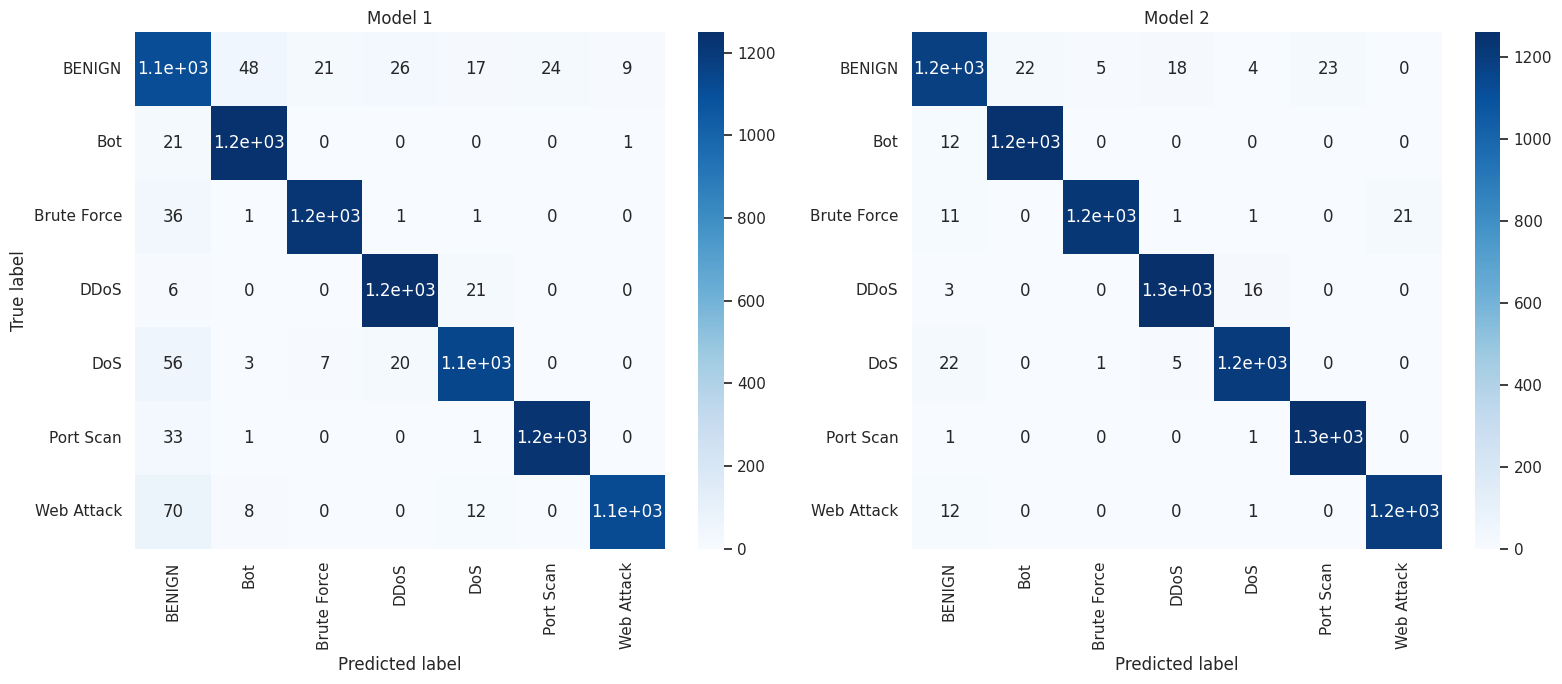

In [ ]:
# Random Forest Models
y_pred_rf1 = rf1.predict(X_test)
y_pred_rf2 = rf2.predict(X_test)

conf_matrix_model1 = confusion_matrix(y_test, y_pred_rf1)
conf_matrix_model2 = confusion_matrix(y_test, y_pred_rf2)

fig, axs = plt.subplots(1, 2, figsize = (16, 7))

sns.heatmap(conf_matrix_model1, annot = True, cmap = 'Blues', ax = axs[0], xticklabels = rf1.classes_, yticklabels = rf1.classes_)
axs[0].set_title('Model 1')

sns.heatmap(conf_matrix_model2, annot = True, cmap = 'Blues', ax = axs[1], xticklabels = rf2.classes_, yticklabels = rf2.classes_)
axs[1].set_title('Model 2')

axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()
plt.show()

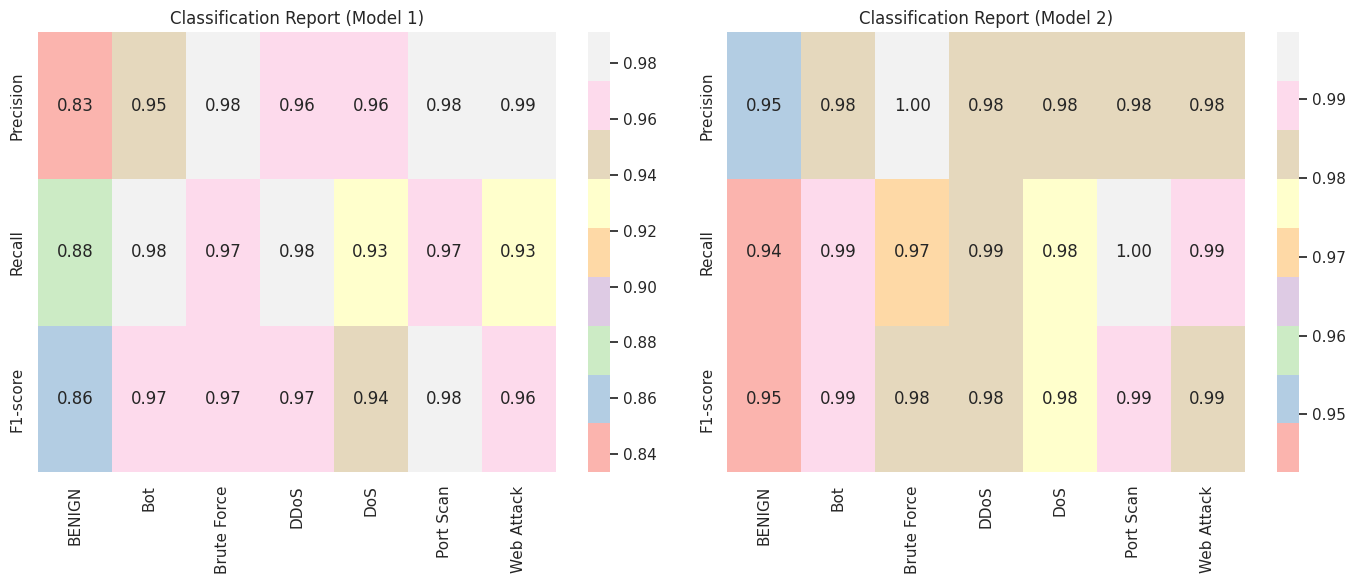

In [ ]:
target_names = rf1.classes_
metrics1 = classification_report(y_true = y_test, y_pred = y_pred_rf1, target_names = target_names, output_dict = True)
precision1 = [metrics1[target_name]['precision'] for target_name in target_names]
recall1 = [metrics1[target_name]['recall'] for target_name in target_names]
f1_score1 = [metrics1[target_name]['f1-score'] for target_name in target_names]

metrics2 = classification_report(y_true = y_test, y_pred = y_pred_rf2, target_names = target_names, output_dict = True)
precision2 = [metrics2[target_name]['precision'] for target_name in target_names]
recall2 = [metrics2[target_name]['recall'] for target_name in target_names]
f1_score2 = [metrics2[target_name]['f1-score'] for target_name in target_names]

data1 = np.array([precision1, recall1, f1_score1])
data2 = np.array([precision2, recall2, f1_score2])
rows = ['Precision', 'Recall', 'F1-score']

fig, axs = plt.subplots(1, 2, figsize = (14, 6))
sns.heatmap(data1, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[0])
sns.heatmap(data2, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[1])
axs[0].set_title('Classification Report (Model 1)')
axs[1].set_title('Classification Report (Model 2)')
fig.tight_layout()
plt.show()

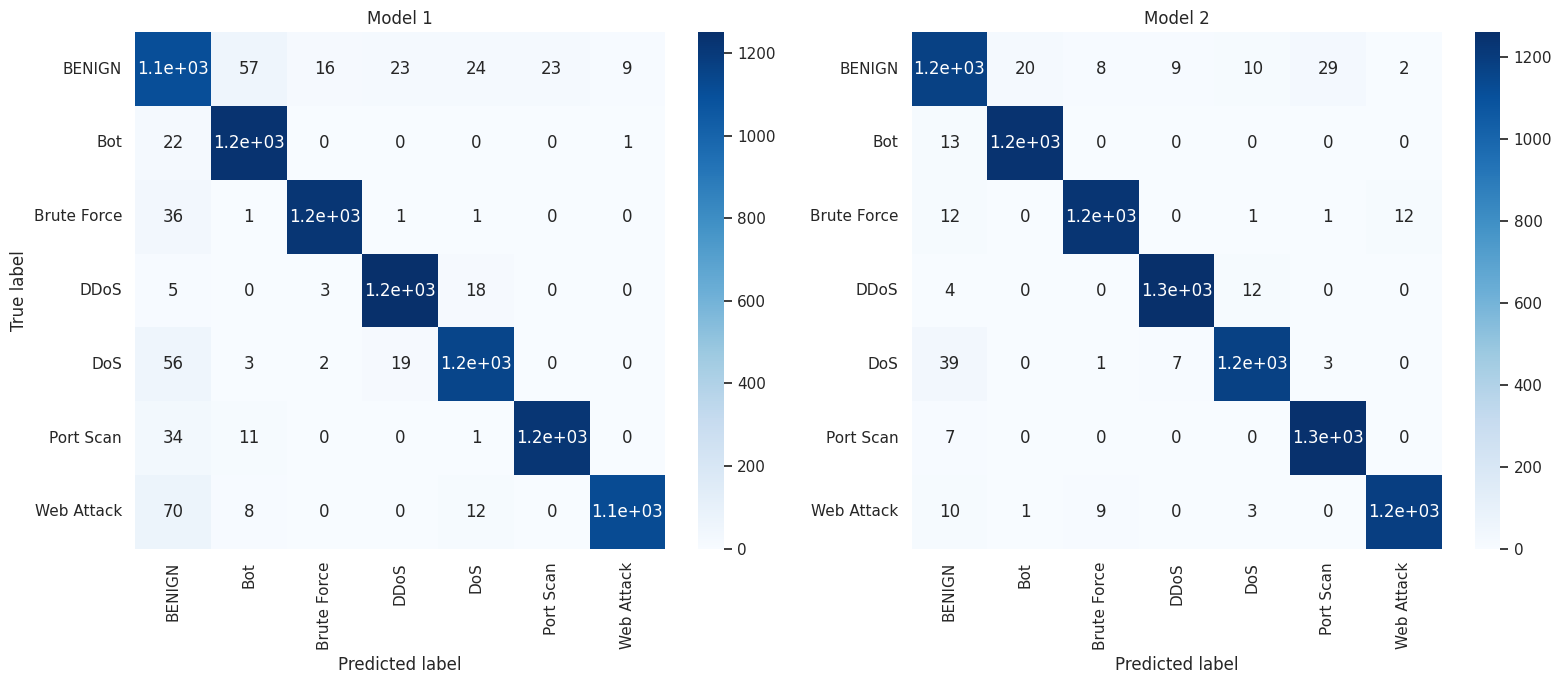

In [ ]:
# Decision Trees
y_pred_dt1 = dt1.predict(X_test)
y_pred_dt2 = dt2.predict(X_test)

conf_matrix_model1 = confusion_matrix(y_test, y_pred_dt1)
conf_matrix_model2 = confusion_matrix(y_test, y_pred_dt2)

fig, axs = plt.subplots(1, 2, figsize = (16, 7))

sns.heatmap(conf_matrix_model1, annot = True, cmap = 'Blues', ax = axs[0], xticklabels = dt1.classes_, yticklabels = dt1.classes_)
axs[0].set_title('Model 1')

sns.heatmap(conf_matrix_model2, annot = True, cmap = 'Blues', ax = axs[1], xticklabels = dt2.classes_, yticklabels = dt2.classes_)
axs[1].set_title('Model 2')

axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()
plt.show()

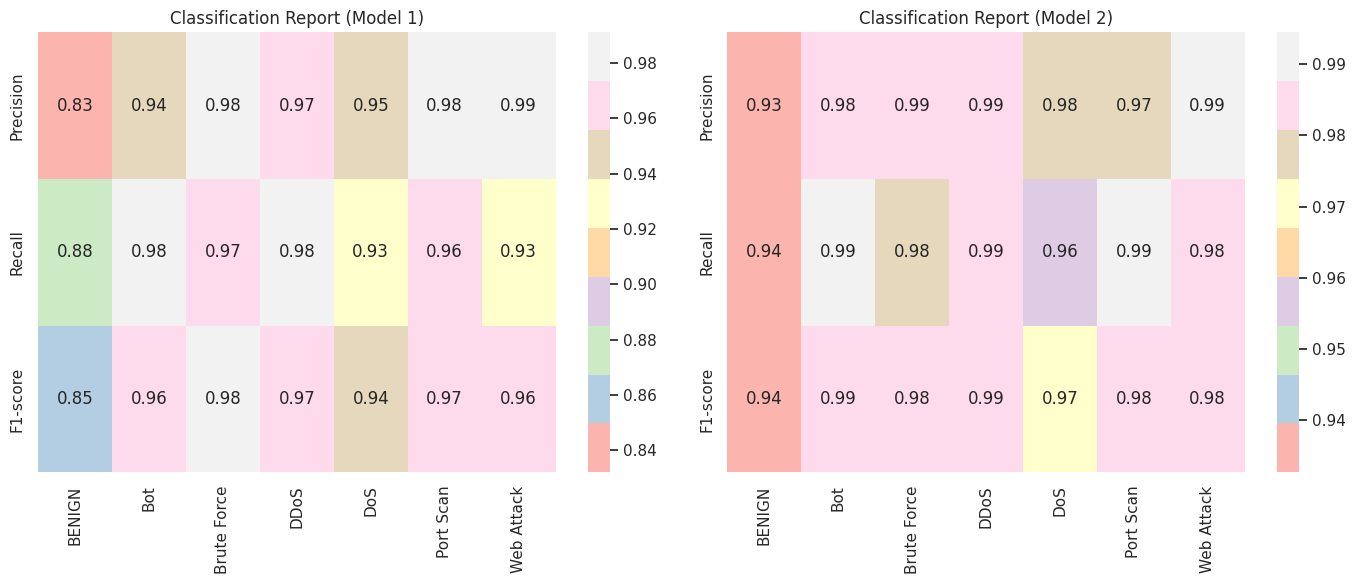

In [ ]:
target_names = dt1.classes_
metrics1 = classification_report(y_true = y_test, y_pred = y_pred_dt1, target_names = target_names, output_dict = True)
precision1 = [metrics1[target_name]['precision'] for target_name in target_names]
recall1 = [metrics1[target_name]['recall'] for target_name in target_names]
f1_score1 = [metrics1[target_name]['f1-score'] for target_name in target_names]

metrics2 = classification_report(y_true = y_test, y_pred = y_pred_dt2, target_names = target_names, output_dict = True)
precision2 = [metrics2[target_name]['precision'] for target_name in target_names]
recall2 = [metrics2[target_name]['recall'] for target_name in target_names]
f1_score2 = [metrics2[target_name]['f1-score'] for target_name in target_names]

data1 = np.array([precision1, recall1, f1_score1])
data2 = np.array([precision2, recall2, f1_score2])
rows = ['Precision', 'Recall', 'F1-score']

fig, axs = plt.subplots(1, 2, figsize = (14, 6))
sns.heatmap(data1, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[0])
sns.heatmap(data2, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[1])
axs[0].set_title('Classification Report (Model 1)')
axs[1].set_title('Classification Report (Model 2)')
fig.tight_layout()
plt.show()

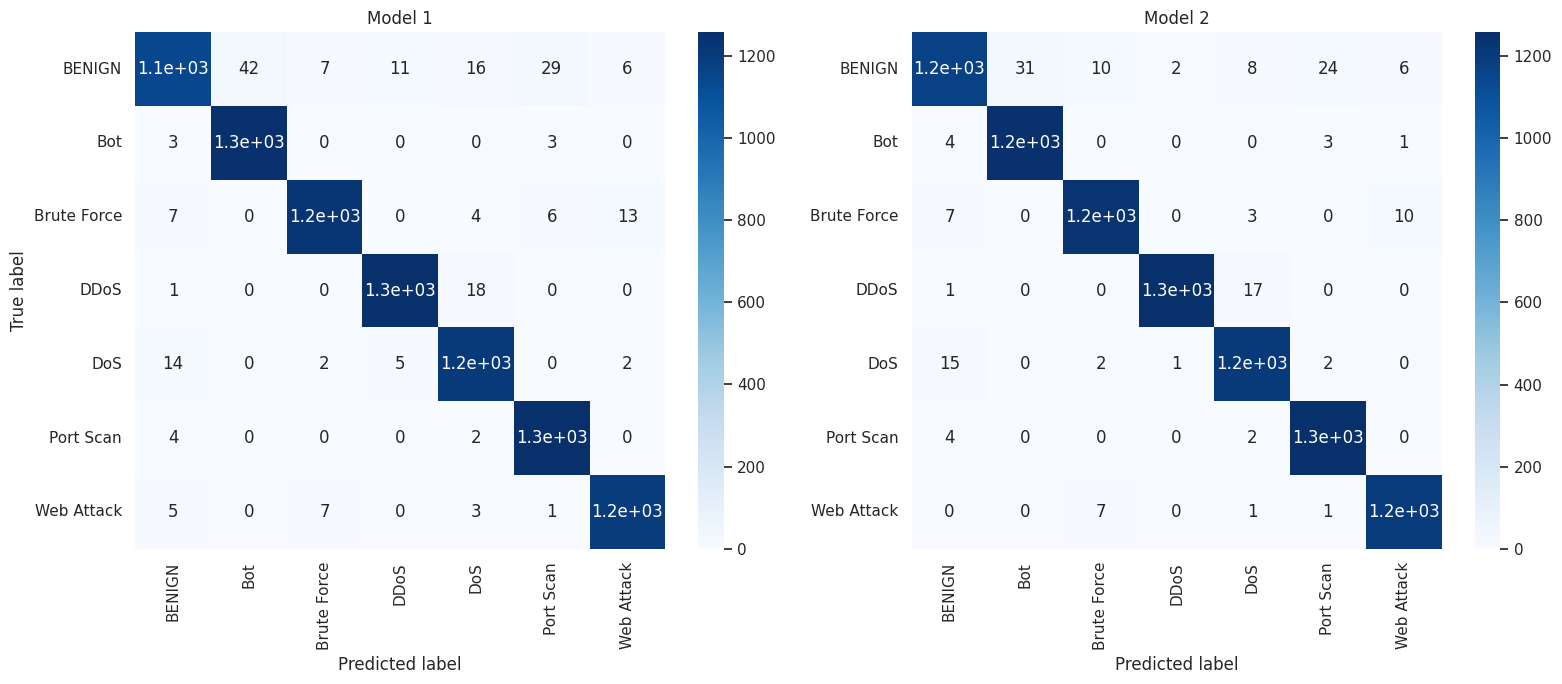

In [ ]:
# KNN
y_pred_knn1 = knn1.predict(X_test)
y_pred_knn2 = knn2.predict(X_test)

conf_matrix_model1 = confusion_matrix(y_test, y_pred_knn1)
conf_matrix_model2 = confusion_matrix(y_test, y_pred_knn2)

fig, axs = plt.subplots(1, 2, figsize = (16, 7))

sns.heatmap(conf_matrix_model1, annot = True, cmap = 'Blues', ax = axs[0], xticklabels = knn1.classes_, yticklabels = knn1.classes_)
axs[0].set_title('Model 1')

sns.heatmap(conf_matrix_model2, annot = True, cmap = 'Blues', ax = axs[1], xticklabels = knn2.classes_, yticklabels = knn2.classes_)
axs[1].set_title('Model 2')

axs[0].set_xlabel('Predicted label')
axs[0].set_ylabel('True label')
axs[1].set_xlabel('Predicted label')

fig.tight_layout()
plt.show()

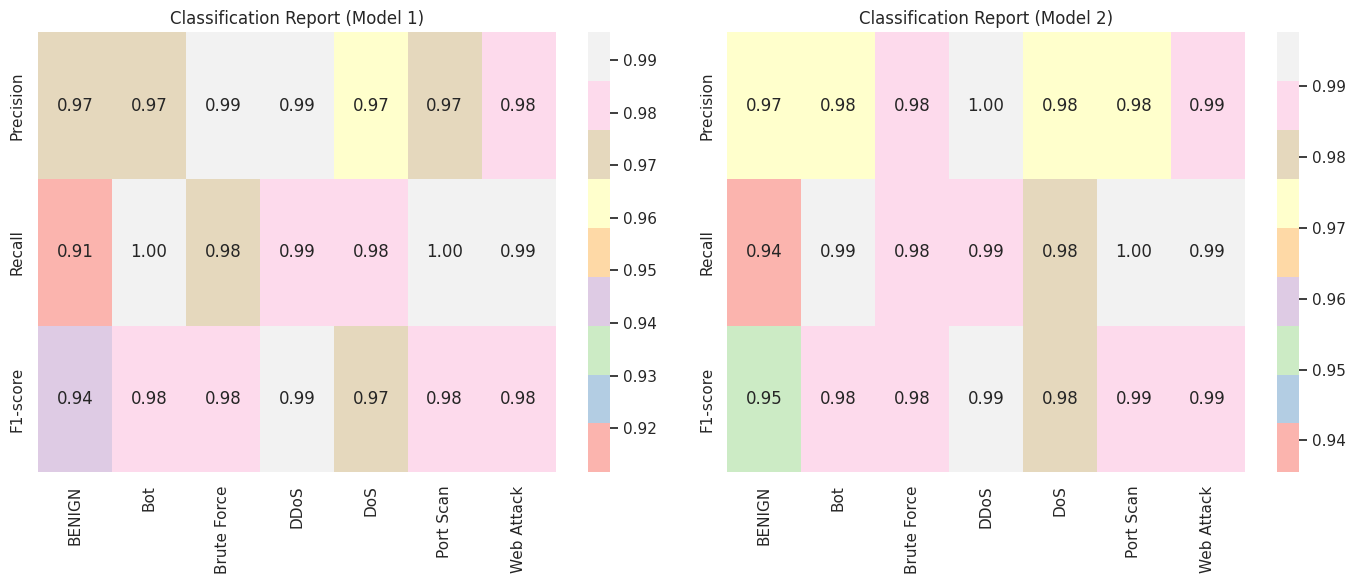

In [ ]:
target_names = knn1.classes_
metrics1 = classification_report(y_true = y_test, y_pred = y_pred_knn1, target_names = target_names, output_dict = True)
precision1 = [metrics1[target_name]['precision'] for target_name in target_names]
recall1 = [metrics1[target_name]['recall'] for target_name in target_names]
f1_score1 = [metrics1[target_name]['f1-score'] for target_name in target_names]

metrics2 = classification_report(y_true = y_test, y_pred = y_pred_knn2, target_names = target_names, output_dict = True)
precision2 = [metrics2[target_name]['precision'] for target_name in target_names]
recall2 = [metrics2[target_name]['recall'] for target_name in target_names]
f1_score2 = [metrics2[target_name]['f1-score'] for target_name in target_names]

data1 = np.array([precision1, recall1, f1_score1])
data2 = np.array([precision2, recall2, f1_score2])
rows = ['Precision', 'Recall', 'F1-score']

fig, axs = plt.subplots(1, 2, figsize = (14, 6))
sns.heatmap(data1, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[0])
sns.heatmap(data2, cmap = 'Pastel1', annot = True, fmt = '.2f', xticklabels = target_names, yticklabels = rows, ax = axs[1])
axs[0].set_title('Classification Report (Model 1)')
axs[1].set_title('Classification Report (Model 2)')
fig.tight_layout()
plt.show()

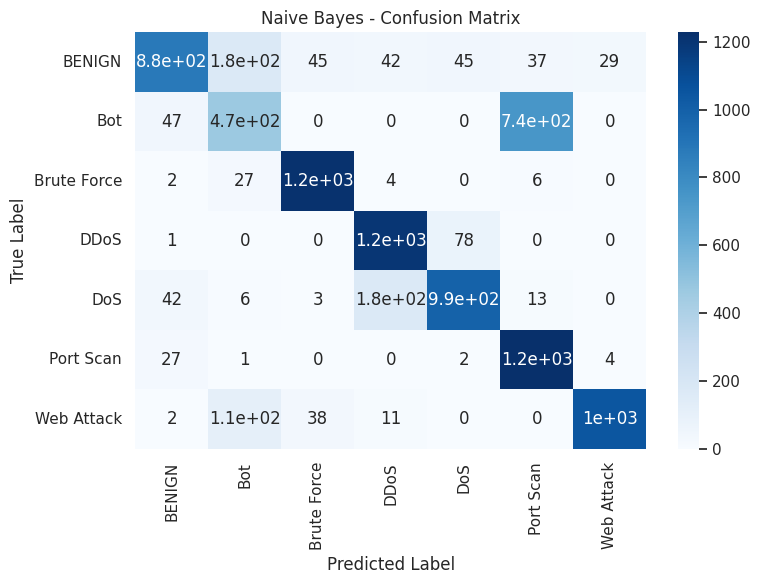

In [ ]:
# Predict using Naive Bayes
y_pred_nb = nb_model.predict(X_test)

# Compute confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Plot single heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, cmap='Blues',
            xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)

plt.title('Naive Bayes - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

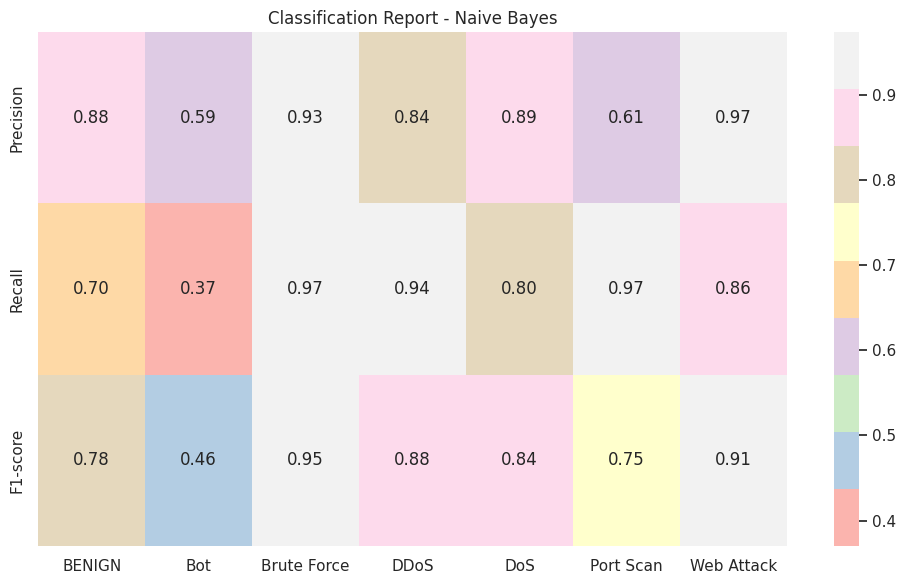

In [ ]:
# Get class labels
target_names = nb_model.classes_

# Compute classification metrics
metrics1 = classification_report(y_true=y_test, y_pred=y_pred_nb, target_names=target_names, output_dict=True)

# Extract precision, recall, f1-score
precision1 = [metrics1[target]['precision'] for target in target_names]
recall1 = [metrics1[target]['recall'] for target in target_names]
f1_score1 = [metrics1[target]['f1-score'] for target in target_names]

# Prepare data for heatmap
data1 = np.array([precision1, recall1, f1_score1])
rows = ['Precision', 'Recall', 'F1-score']

# Plot single heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data1, cmap='Pastel1', annot=True, fmt='.2f',
            xticklabels=target_names, yticklabels=rows)

plt.title('Classification Report - Naive Bayes')
plt.tight_layout()
plt.show()

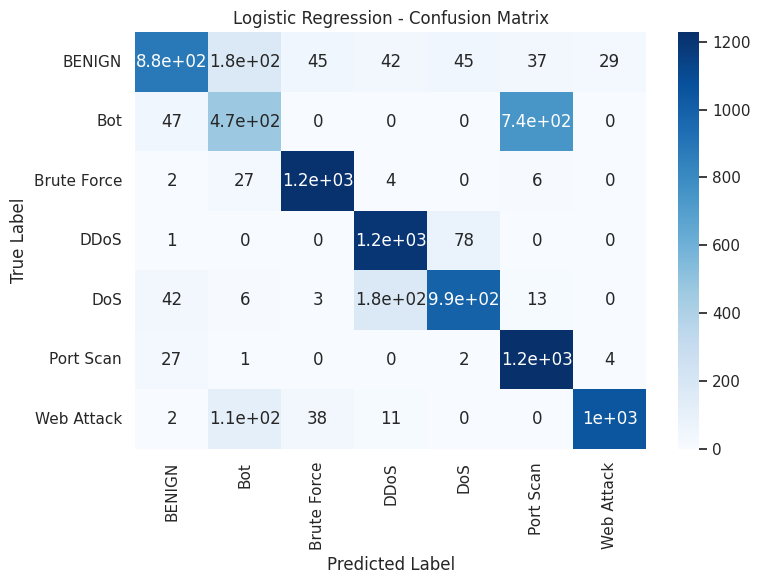

In [ ]:
# Predict using Logistic Regression
y_pred_lr = lr_model.predict(X_test)

# Compute confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_nb)

# Plot single heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, cmap='Blues',
            xticklabels=lr_model.classes_, yticklabels=lr_model.classes_)

plt.title('Logistic Regression - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

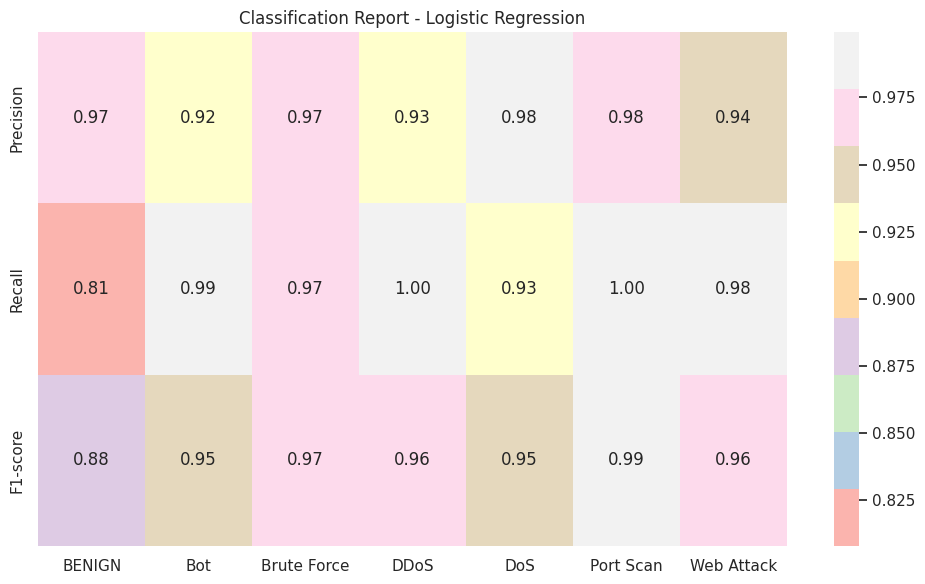

In [ ]:
# Get class labels
target_names = lr_model.classes_

# Compute classification metrics
metrics1 = classification_report(y_true=y_test, y_pred=y_pred_lr, target_names=target_names, output_dict=True)

# Extract precision, recall, f1-score
precision1 = [metrics1[target]['precision'] for target in target_names]
recall1 = [metrics1[target]['recall'] for target in target_names]
f1_score1 = [metrics1[target]['f1-score'] for target in target_names]

# Prepare data for heatmap
data1 = np.array([precision1, recall1, f1_score1])
rows = ['Precision', 'Recall', 'F1-score']

# Plot single heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data1, cmap='Pastel1', annot=True, fmt='.2f',
            xticklabels=target_names, yticklabels=rows)

plt.title('Classification Report - Logistic Regression')
plt.tight_layout()
plt.show()

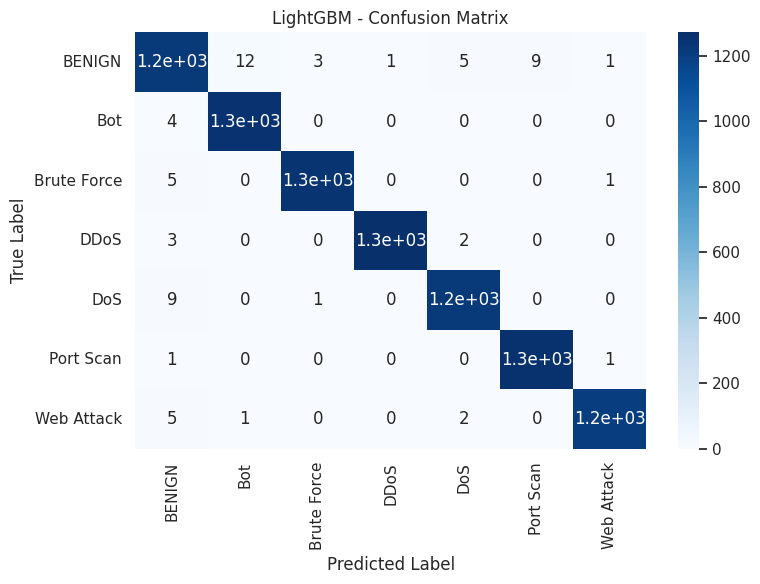

In [ ]:
# Predict using LightGBM
y_pred_lgb = lgb_model.predict(X_test)

# Compute confusion matrix
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

# Plot single heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, cmap='Blues',
            xticklabels=lgb_model.classes_, yticklabels=lgb_model.classes_)

plt.title('LightGBM - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

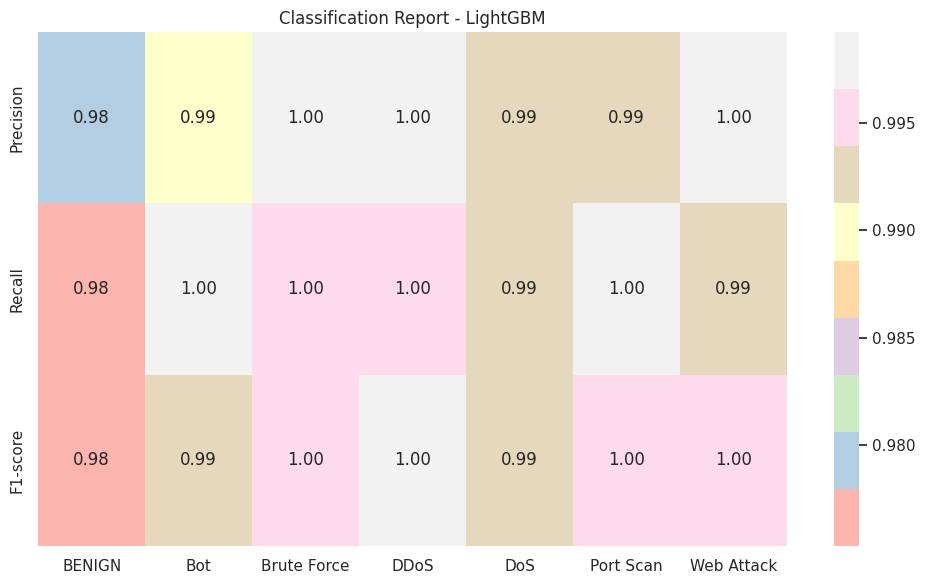

In [ ]:
# Get class labels
target_names = lgb_model.classes_

# Compute classification metrics
metrics1 = classification_report(y_true=y_test, y_pred=y_pred_lgb, target_names=target_names, output_dict=True)

# Extract precision, recall, f1-score
precision1 = [metrics1[target]['precision'] for target in target_names]
recall1 = [metrics1[target]['recall'] for target in target_names]
f1_score1 = [metrics1[target]['f1-score'] for target in target_names]

# Prepare data for heatmap
data1 = np.array([precision1, recall1, f1_score1])
rows = ['Precision', 'Recall', 'F1-score']

# Plot single heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data1, cmap='Pastel1', annot=True, fmt='.2f',
            xticklabels=target_names, yticklabels=rows)

plt.title('Classification Report - LightGBM')
plt.tight_layout()
plt.show()

comparision of multi-class algorithms

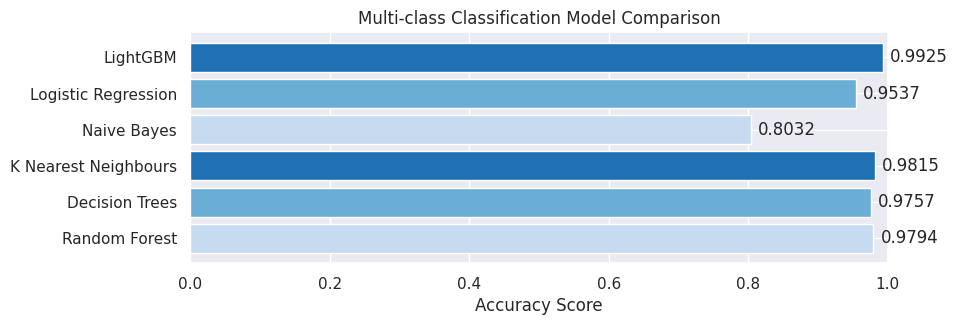

In [ ]:
palette = sns.color_palette('Blues', n_colors = 3)

rf_acc = accuracy_score(y_pred_rf2, y_test)
dt_acc = accuracy_score(y_pred_dt2, y_test)
knn_acc = accuracy_score(y_pred_knn2, y_test)
nb_acc = accuracy_score(y_pred_nb, y_test)
lr_acc = accuracy_score(y_pred_lr, y_test)
lgb_acc = accuracy_score(y_pred_lgb, y_test)

labels = ['Random Forest', 'Decision Trees', 'K Nearest Neighbours', 'Naive Bayes', 'Logistic Regression', 'LightGBM']
scores = [rf_acc, dt_acc, knn_acc, nb_acc, lr_acc, lgb_acc]

fig, ax = plt.subplots(figsize = (9, 3))
ax.barh(labels, scores, color = palette)
ax.set_xlim([0, 1])
ax.set_xlabel('Accuracy Score')
ax.set_title('Multi-class Classification Model Comparison')

for i, v in enumerate(scores):
    ax.text(v + 0.01, i, str(round(v, 4)), ha = 'left', va = 'center')

plt.show()

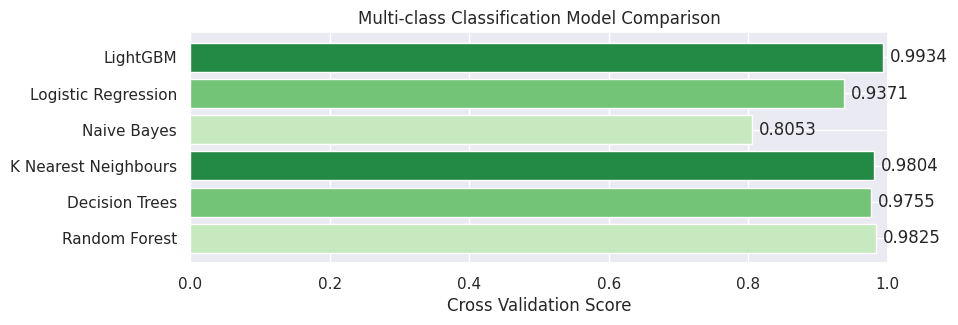

In [ ]:
palette = sns.color_palette('Greens', n_colors = 3)

labels = ['Random Forest', 'Decision Trees', 'K Nearest Neighbours', 'Naive Bayes', 'Logistic Regression', 'LightGBM']
scores = [cv_rf2.mean(), cv_dt2.mean(), cv_knn2.mean(), cv_nb_model.mean(), cv_lr_model.mean(), cv_lgb_model.mean()]

fig, ax = plt.subplots(figsize = (9, 3))
ax.barh(labels, scores, color = palette)
ax.set_xlim([0, 1])
ax.set_xlabel('Cross Validation Score')
ax.set_title('Multi-class Classification Model Comparison')

for i, v in enumerate(scores):
    ax.text(v + 0.01, i, str(round(v, 4)), ha = 'left', va = 'center')

plt.show()

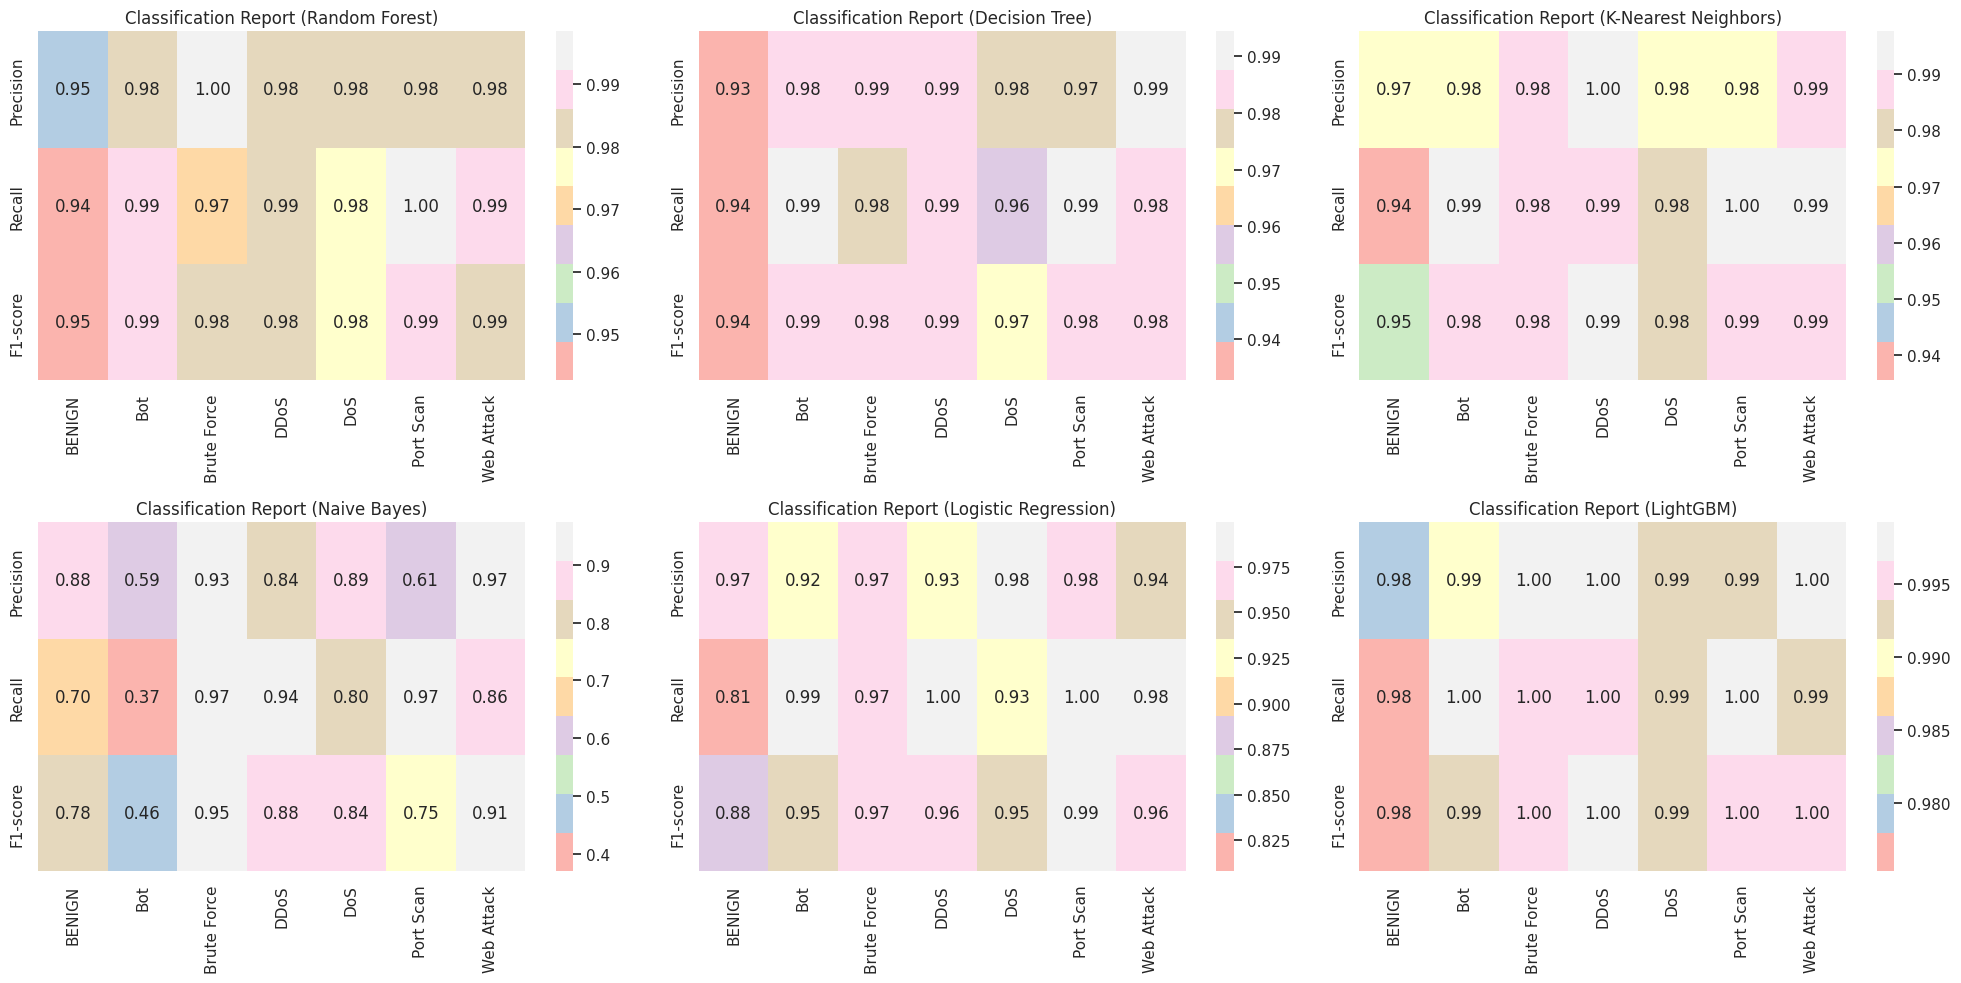

In [ ]:
# List of predictions from different models
preds = [y_pred_rf2, y_pred_dt2, y_pred_knn2, y_pred_nb, y_pred_lr, y_pred_lgb]
model_names = [
    'Random Forest', 'Decision Tree', 'K-Nearest Neighbors',
    'Naive Bayes', 'Logistic Regression', 'LightGBM'
]

# Target class names
target_names = rf2.classes_  # or use your actual label encoder classes

# Collect metrics for each model
datas = []
for pred in preds:
    metrics = classification_report(
        y_true=y_test, y_pred=pred, target_names=target_names, output_dict=True
    )
    precision = [metrics[cls]['precision'] for cls in target_names]
    recall = [metrics[cls]['recall'] for cls in target_names]
    f1_score = [metrics[cls]['f1-score'] for cls in target_names]
    datas.append(np.array([precision, recall, f1_score]))

# Plot heatmaps in a 2x3 grid
rows = ['Precision', 'Recall', 'F1-score']
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, ax in enumerate(axs.flat):
    sns.heatmap(
        datas[i], cmap='Pastel1', annot=True, fmt='.2f',
        xticklabels=target_names, yticklabels=rows, ax=ax
    )
    ax.set_title(f'Classification Report ({model_names[i]})')

plt.tight_layout()
plt.show()

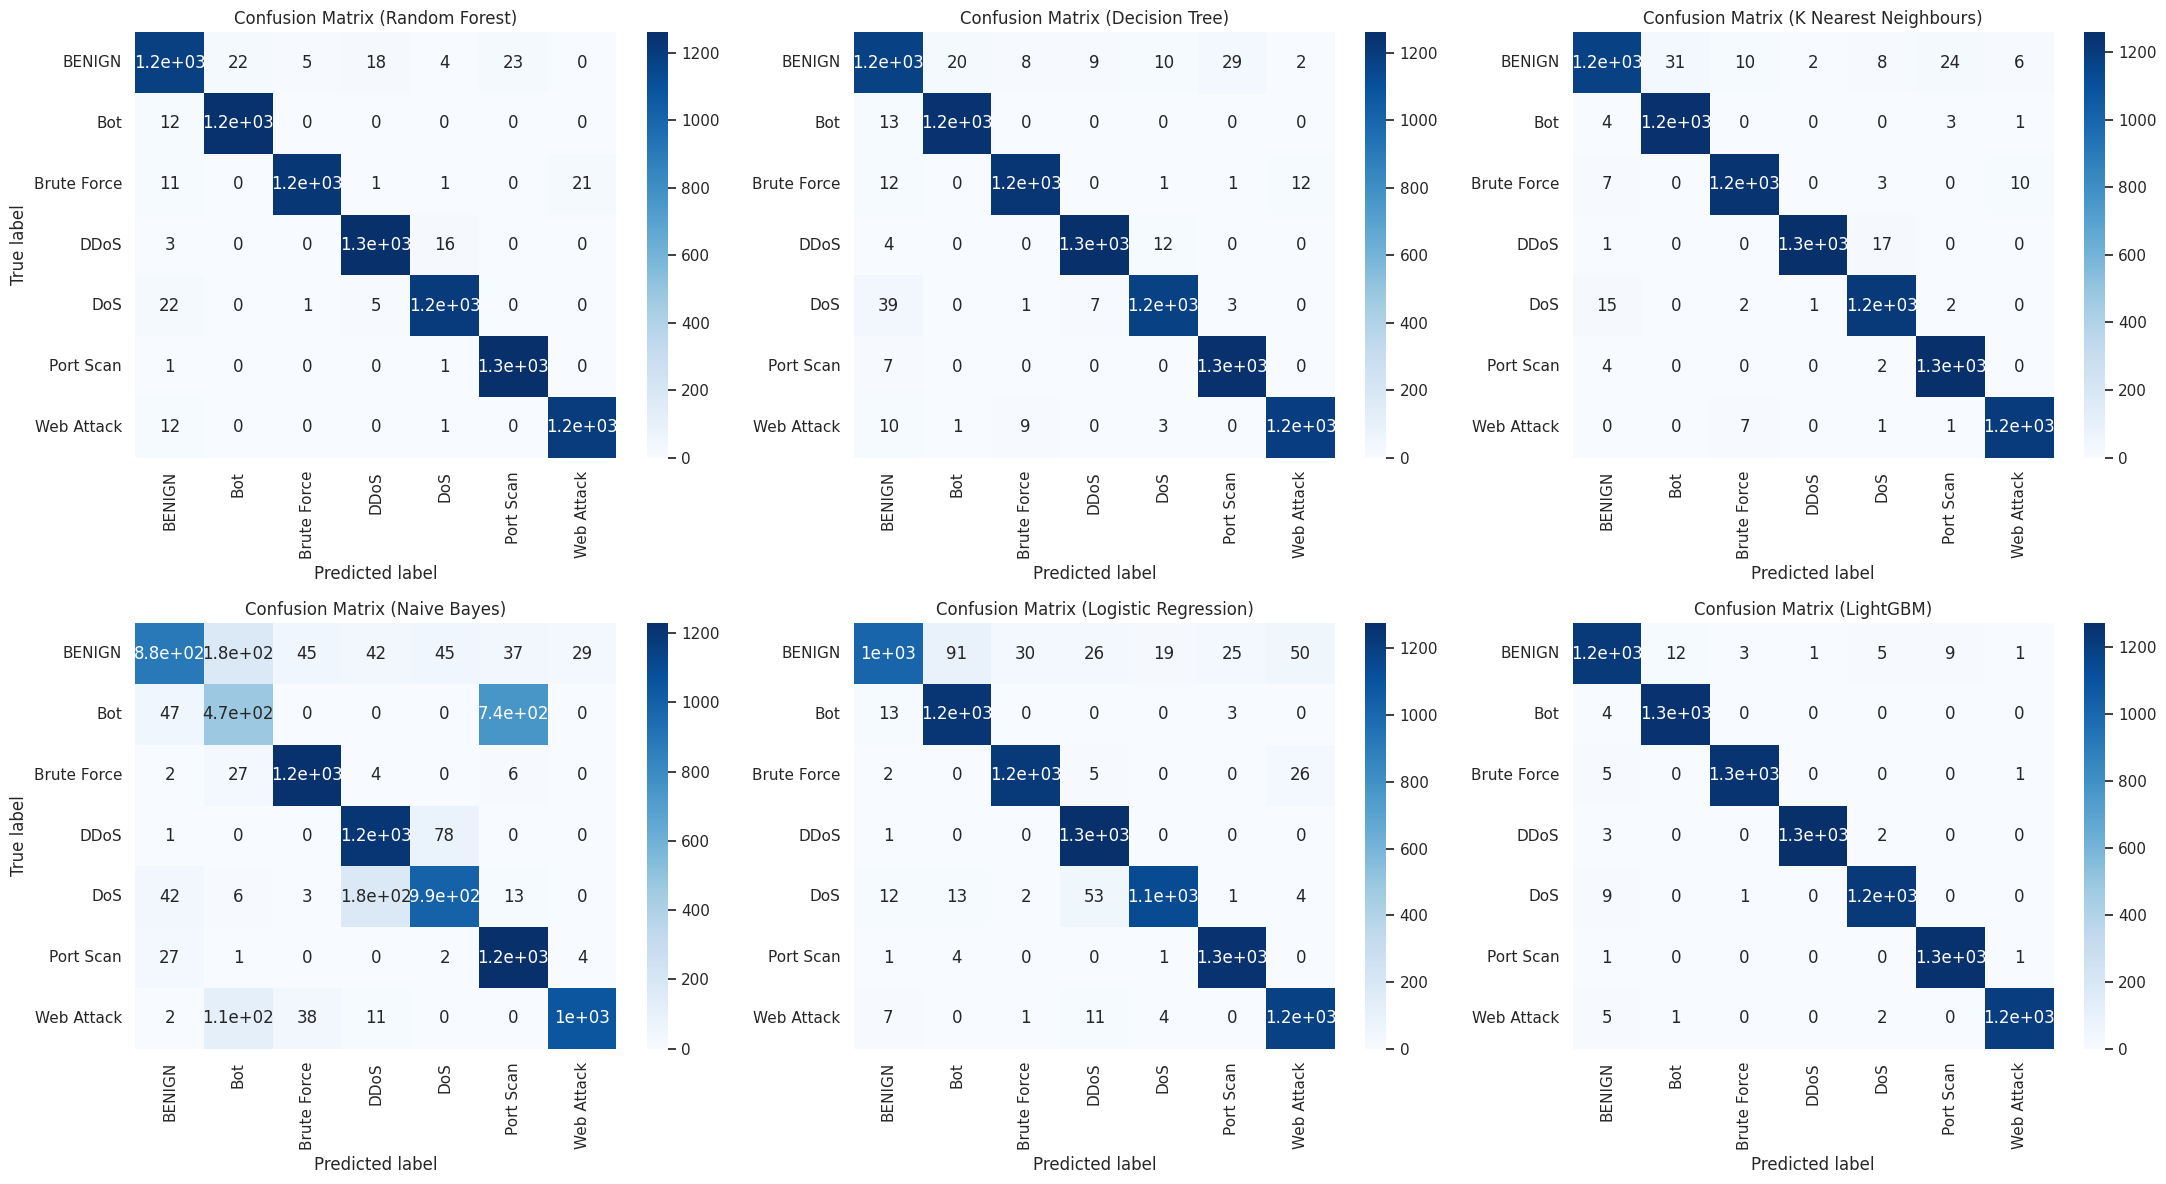

In [ ]:
# List of predictions from 6 models
preds = [y_pred_rf2, y_pred_dt2, y_pred_knn2, y_pred_nb, y_pred_lr, y_pred_lgb]
model_names = [
    'Random Forest', 'Decision Tree', 'K Nearest Neighbours',
    'Naive Bayes', 'Logistic Regression', 'LightGBM'
]

# Compute confusion matrices
conf_matrices = [confusion_matrix(y_test, y_pred) for y_pred in preds]

# Class labels (assuming all models use same labels as rf2)
class_labels = rf2.classes_  # or nb_model.classes_

# Plot 2x3 grid of confusion matrices
fig, axs = plt.subplots(2, 3, figsize=(22, 12))

for i, ax in enumerate(axs.flat):
    sns.heatmap(conf_matrices[i], annot=True, cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title(f'Confusion Matrix ({model_names[i]})')
    ax.set_xlabel('Predicted label')
    if i % 3 == 0:
        ax.set_ylabel('True label')

plt.tight_layout()
plt.show()

# Save The Models

In [ ]:
import joblib

# Save the model to a file
joblib.dump(rf2, '/content/drive/MyDrive/Capstone /CICIDS2017/random_forest_model_2017.joblib')
joblib.dump(dt2, '/content/drive/MyDrive/Capstone /CICIDS2017/decision_tree_model_2017.joblib')
joblib.dump(knn2, '/content/drive/MyDrive/Capstone /CICIDS2017/knn_model_2017.joblib')
joblib.dump(nb_model, '/content/drive/MyDrive/Capstone /CICIDS2017/nb_model_2017.joblib')
joblib.dump(lr_model, '/content/drive/MyDrive/Capstone /CICIDS2017/lr_model_2017.joblib')
joblib.dump(lgb_model, '/content/drive/MyDrive/Capstone /CICIDS2017/lgb_model_2017.joblib')

['/content/drive/MyDrive/Capstone /CICIDS2017/lgb_model_2017.joblib']